
=== Flash Crash Detection for XOM in May 2010 ===

Data for XOM:
   trade_price  trade_volume                  timestamp  bid_price  bid_size  \
0        68.10         990.0 2010-05-03 09:30:01.012999      68.09       1.0   
1        68.10         100.0 2010-05-03 09:30:01.396000      68.09       1.0   
2        68.09         300.0 2010-05-03 09:30:02.023000      68.09       2.0   
3        68.09         150.0 2010-05-03 09:30:02.140999      68.09       1.0   
4        68.12         100.0 2010-05-03 09:30:03.764999      68.08       3.0   

   ask_price  ask_size  mid_price  spread  delta_bid  delta_ask   ofi  \
0      68.09       3.0     68.090    0.00      -0.01      -0.01  0.02   
1      68.09       3.0     68.090    0.00       0.00       0.00  0.00   
2      68.10       2.0     68.095    0.01       0.00       0.01 -0.02   
3      68.10       2.0     68.095    0.01       0.00       0.00  0.00   
4      68.16       4.0     68.120    0.08      -0.01       0.06 -0.27   

         date 

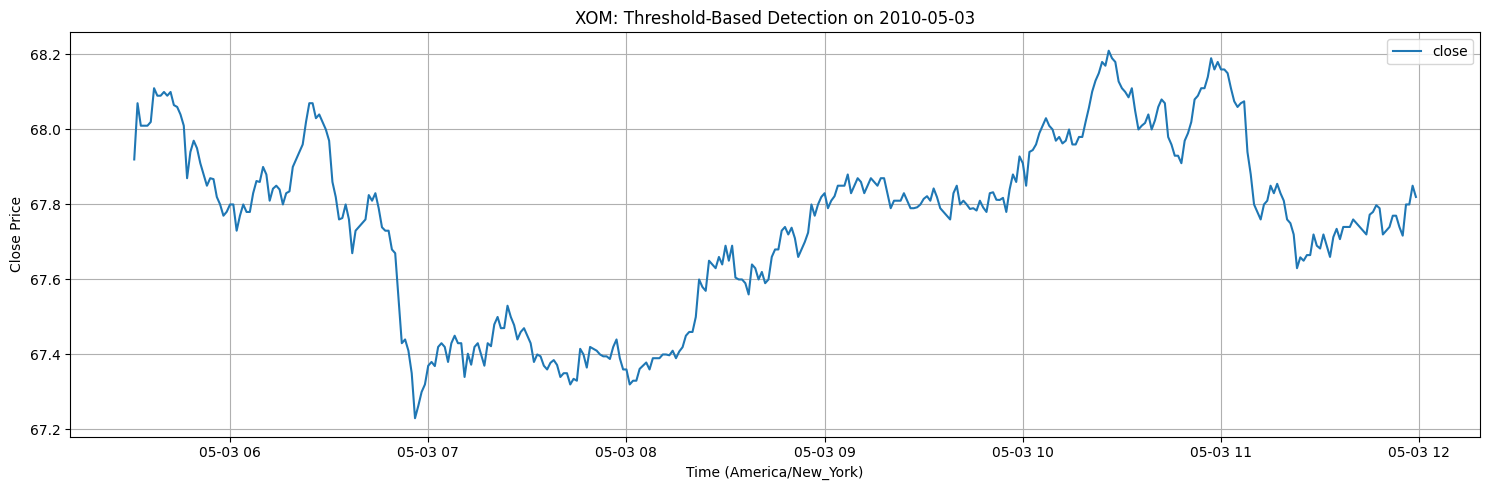

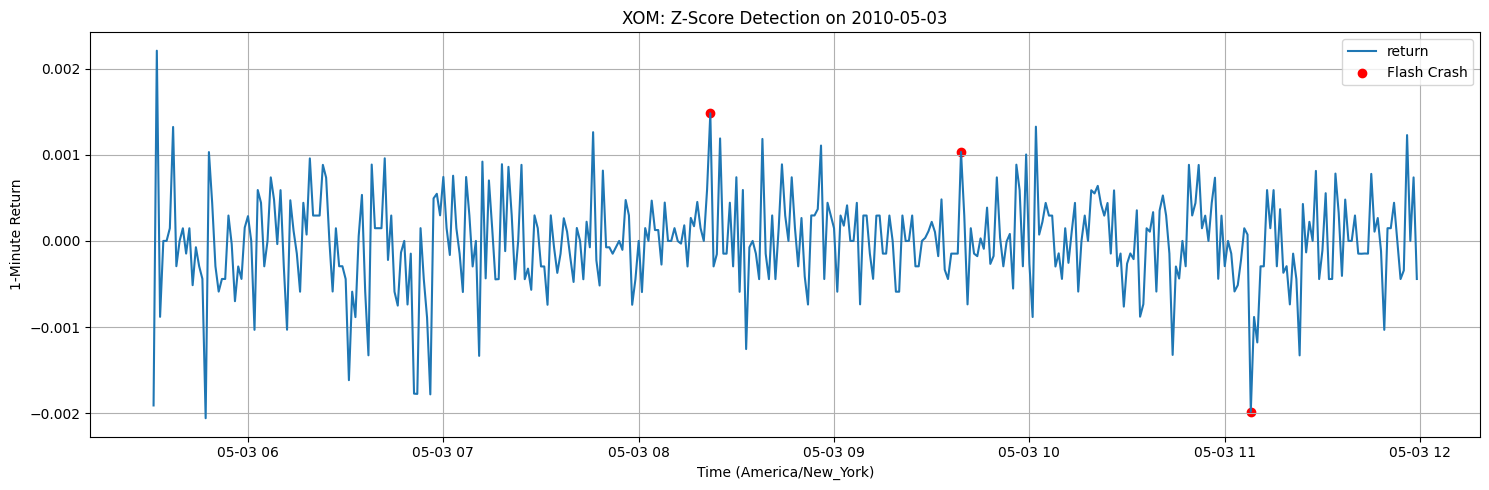

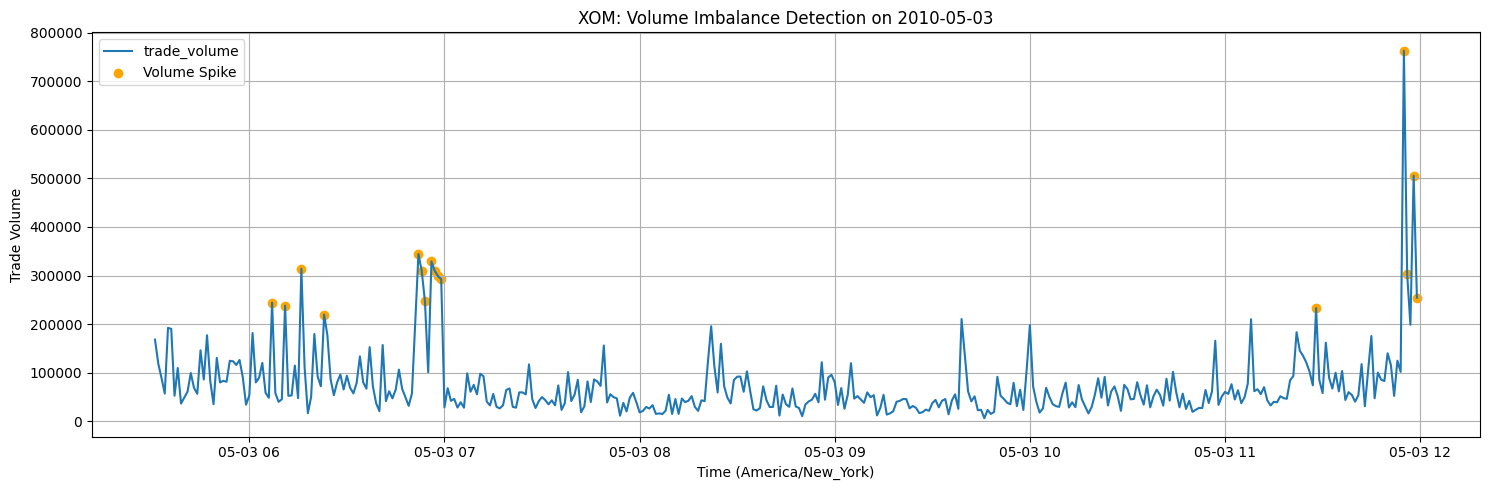

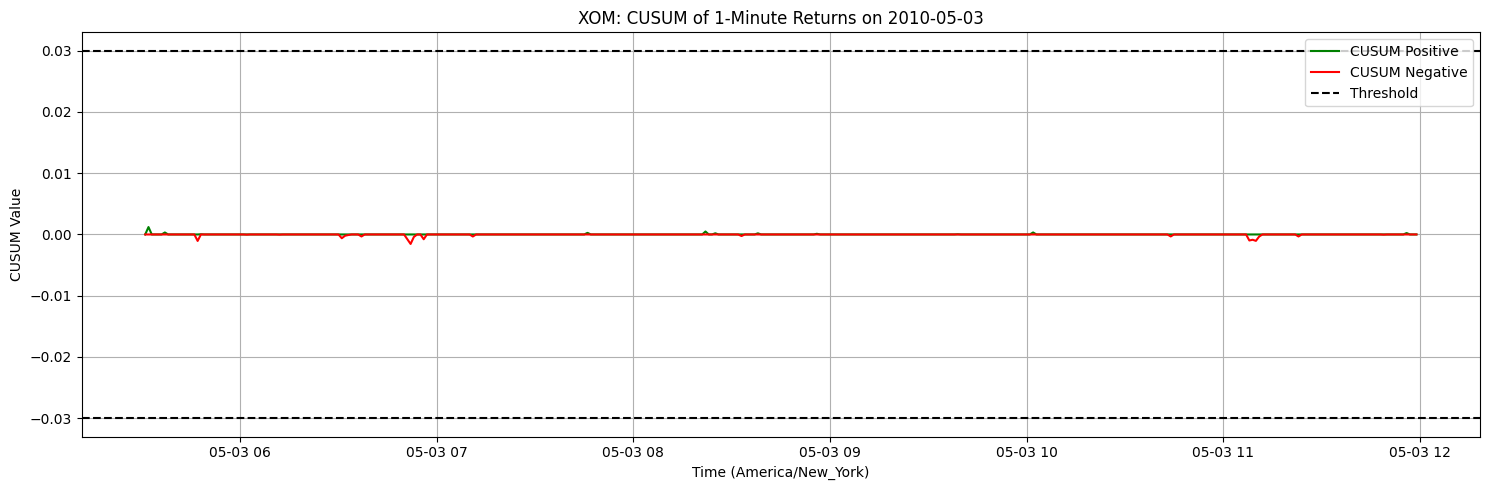

No events to plot for XOM: CUSUM Detection on 2010-05-03.


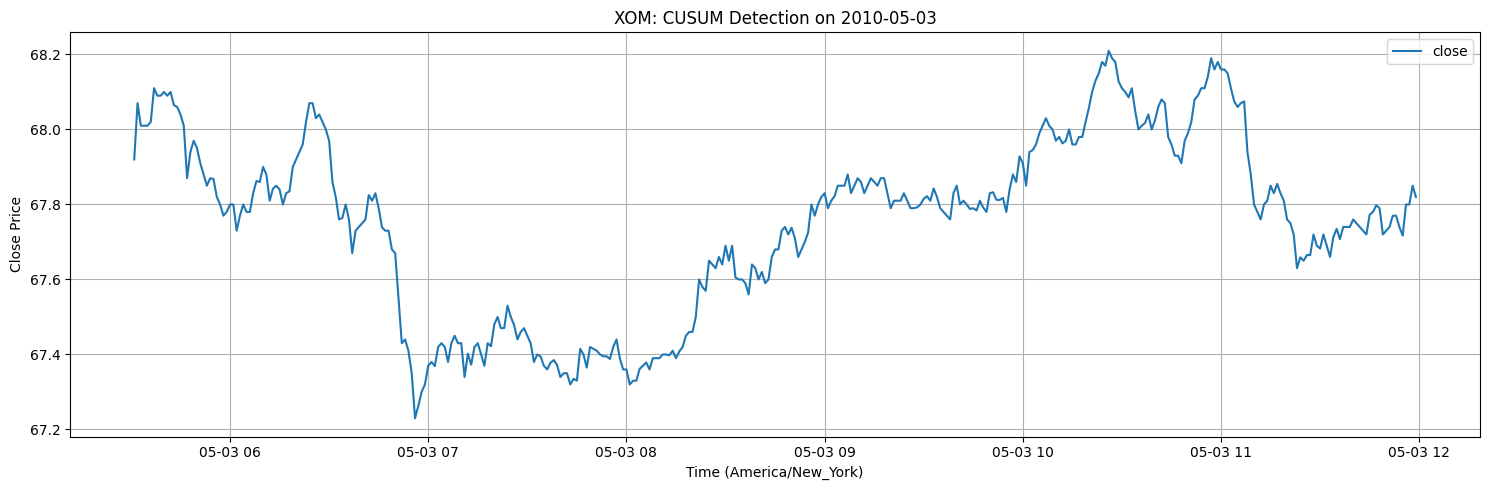

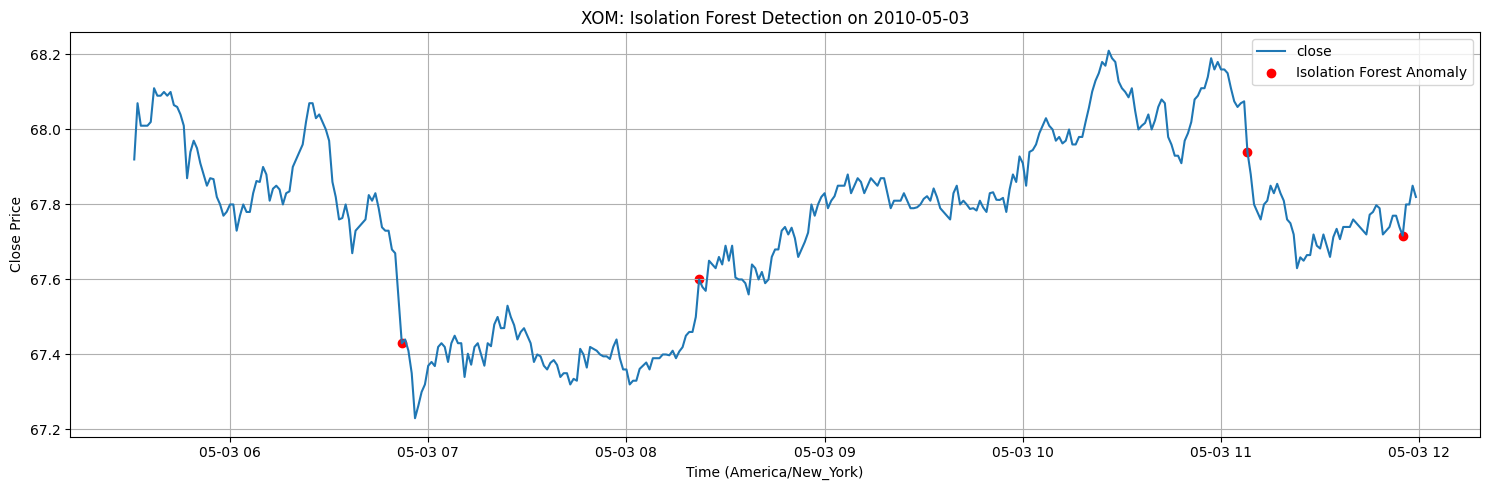

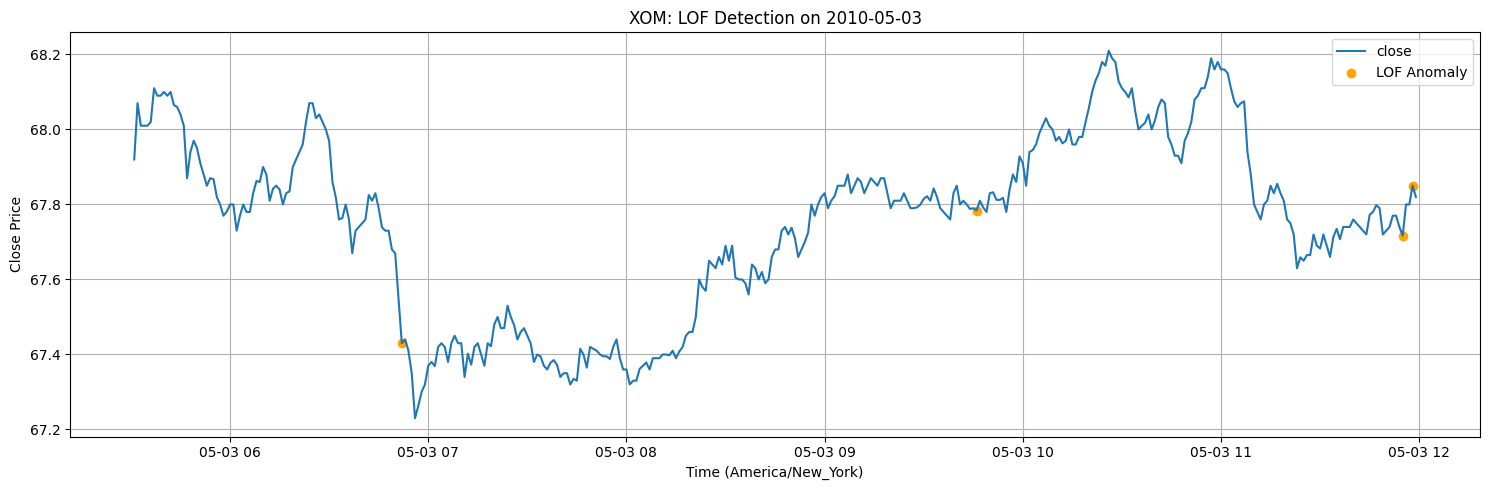

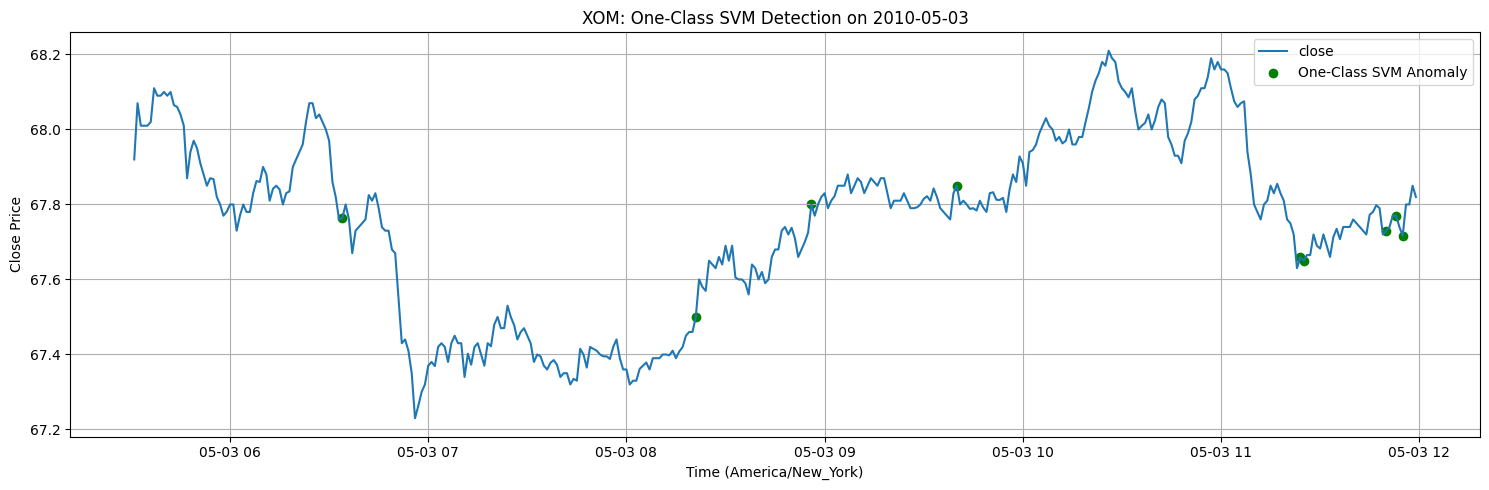

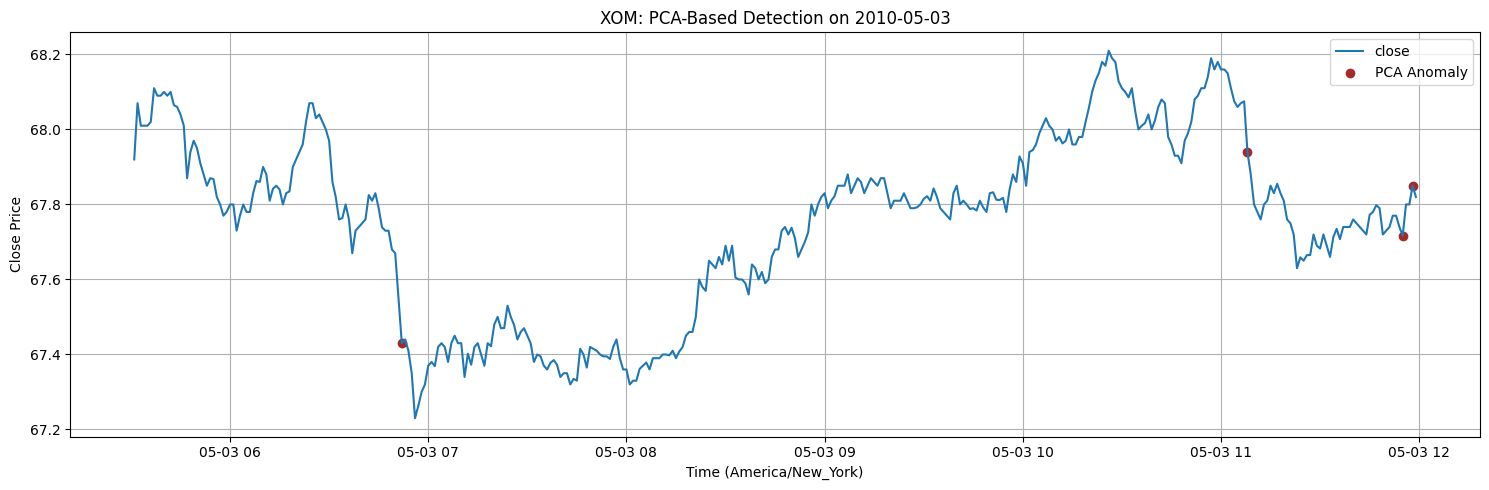


--- Average Detected Events Across 19 Normal Days ---
Threshold: 0.00
Z-Score: 1.26
Volume Imbalance: 13.84
CUSUM: 0.00
Isolation Forest: 4.00
Local Outlier Factor: 4.00
One-Class SVM: 17.05
PCA: 4.00
No events to plot for XOM: Threshold-Based Detection on 2010-05-06.


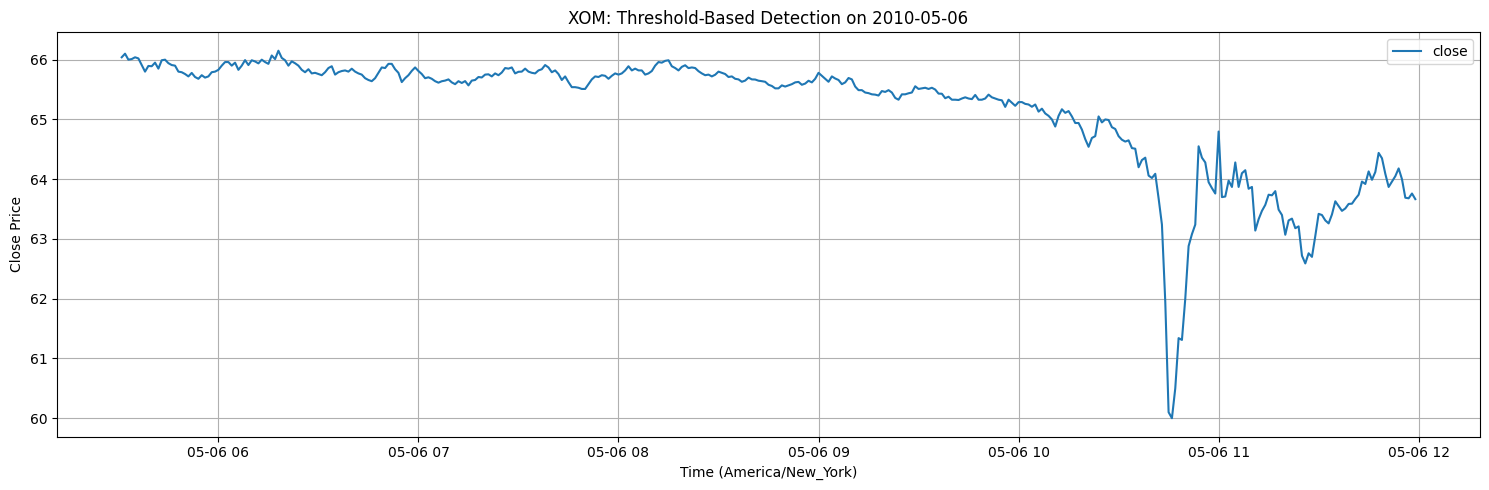

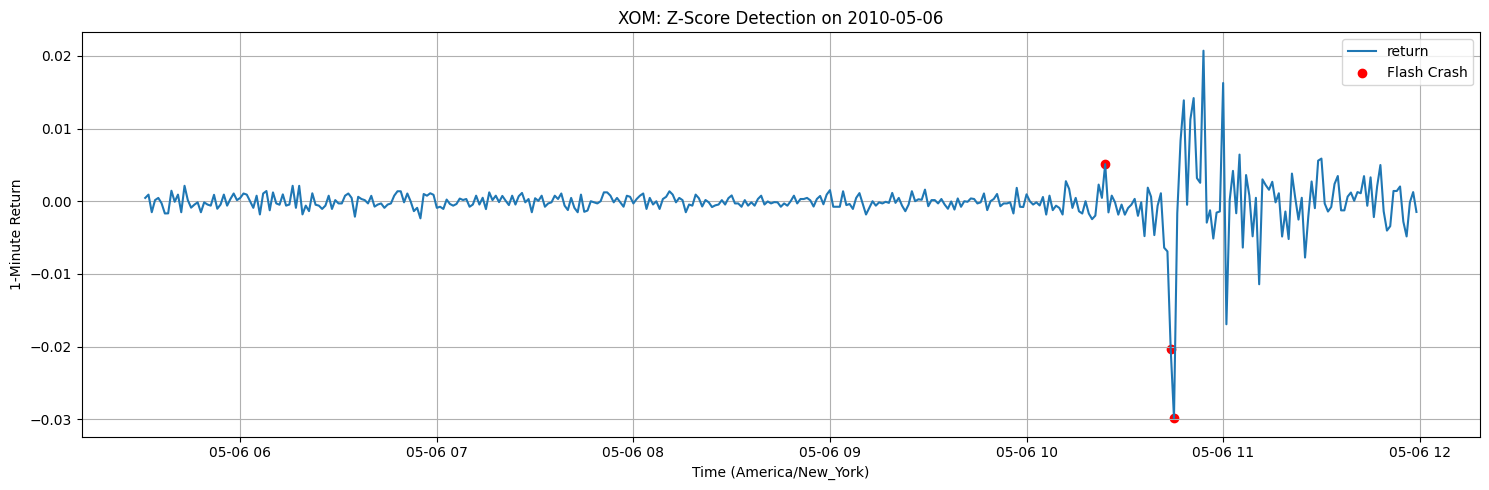

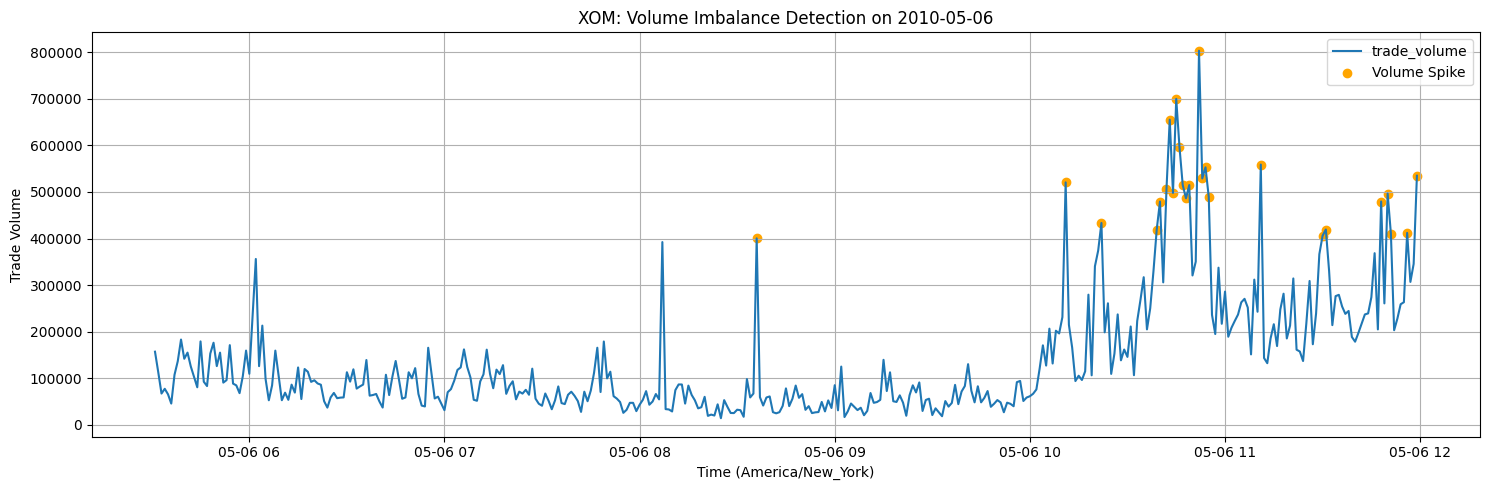

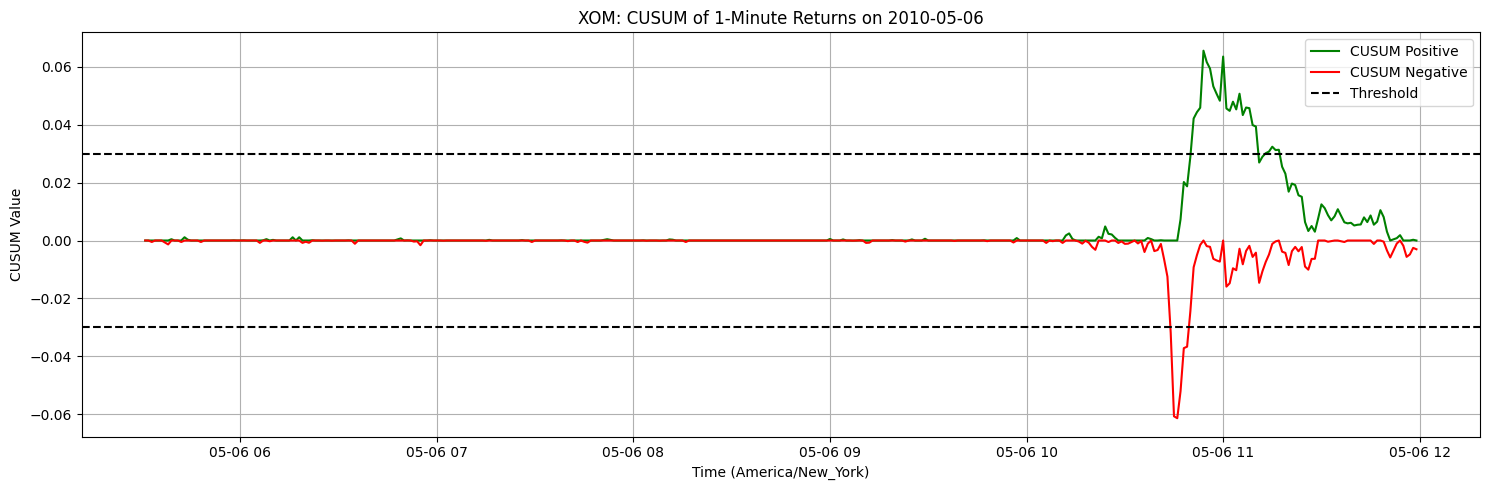

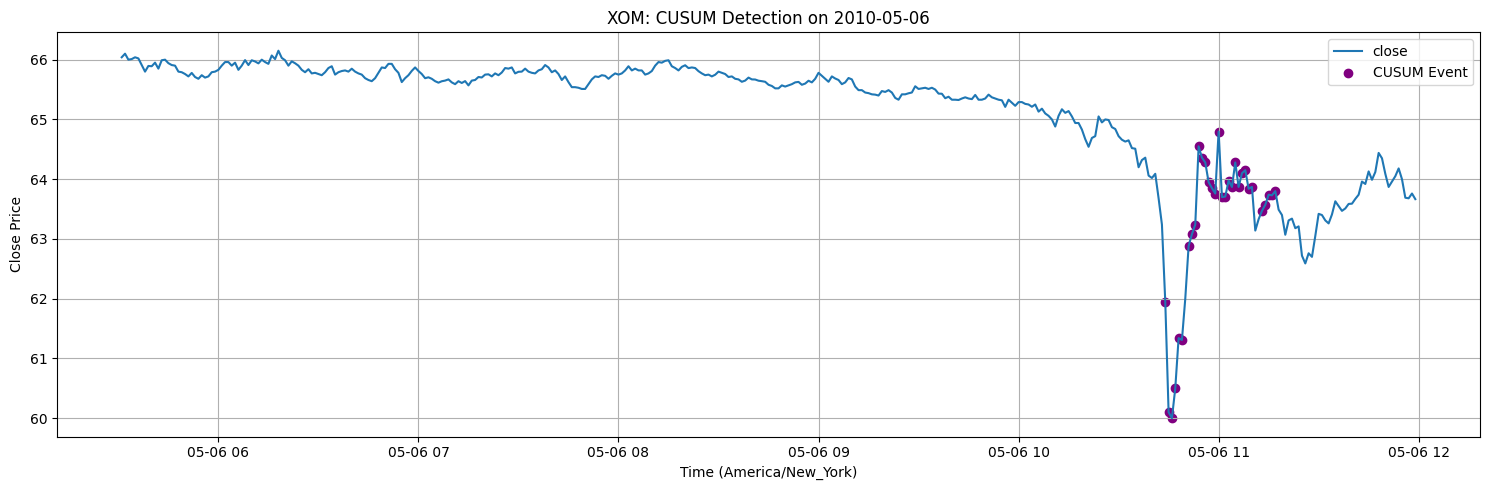

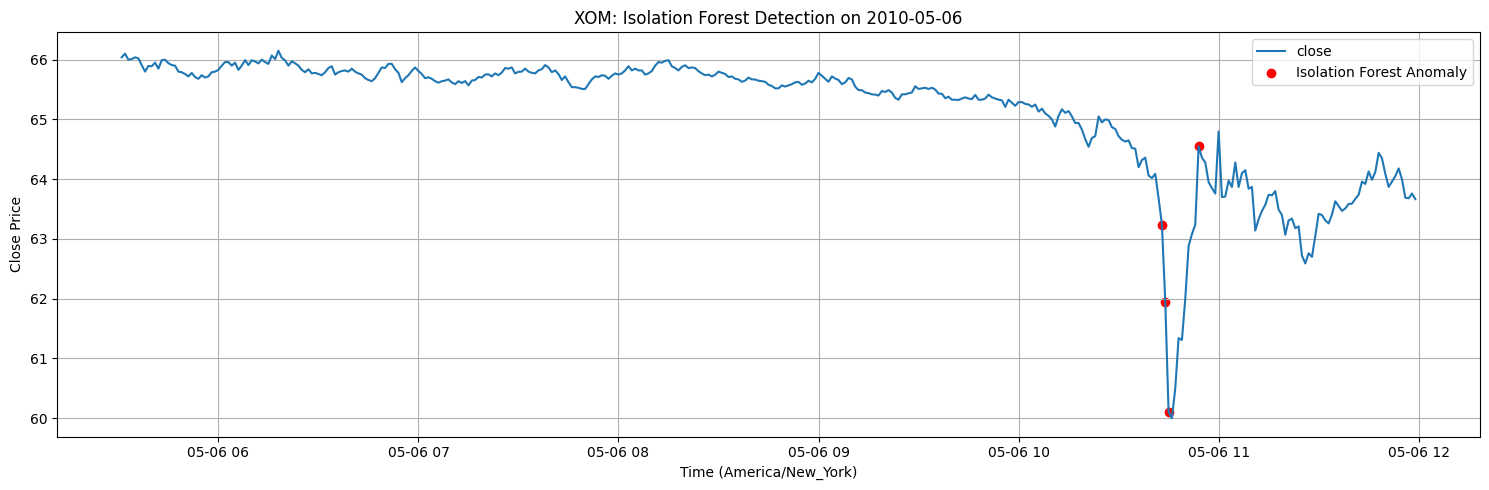

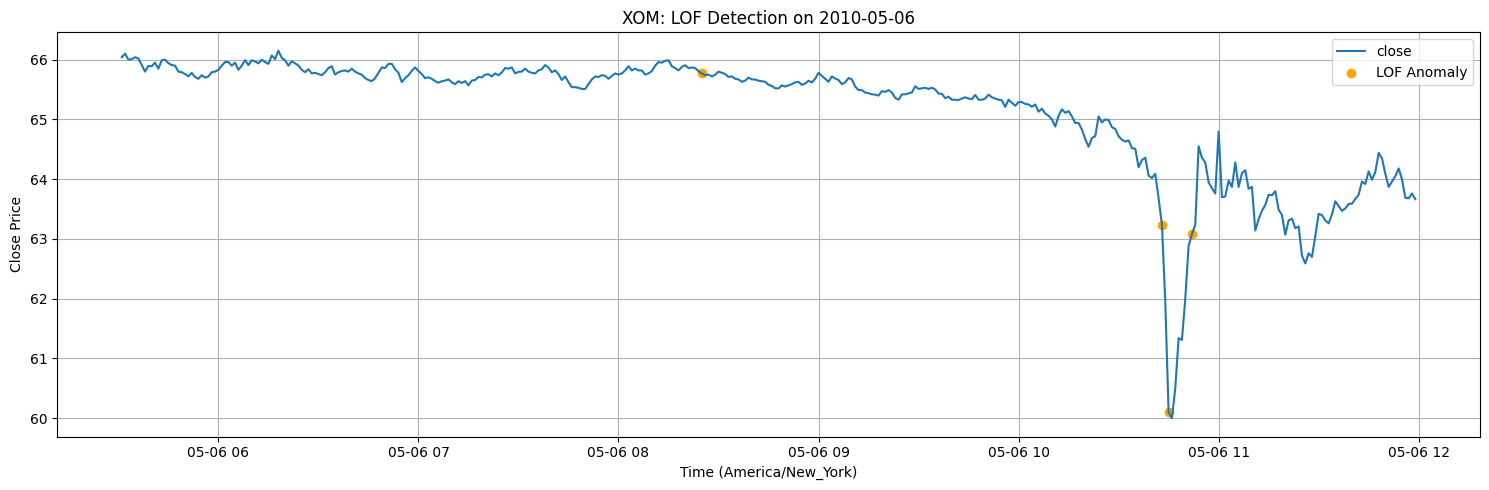

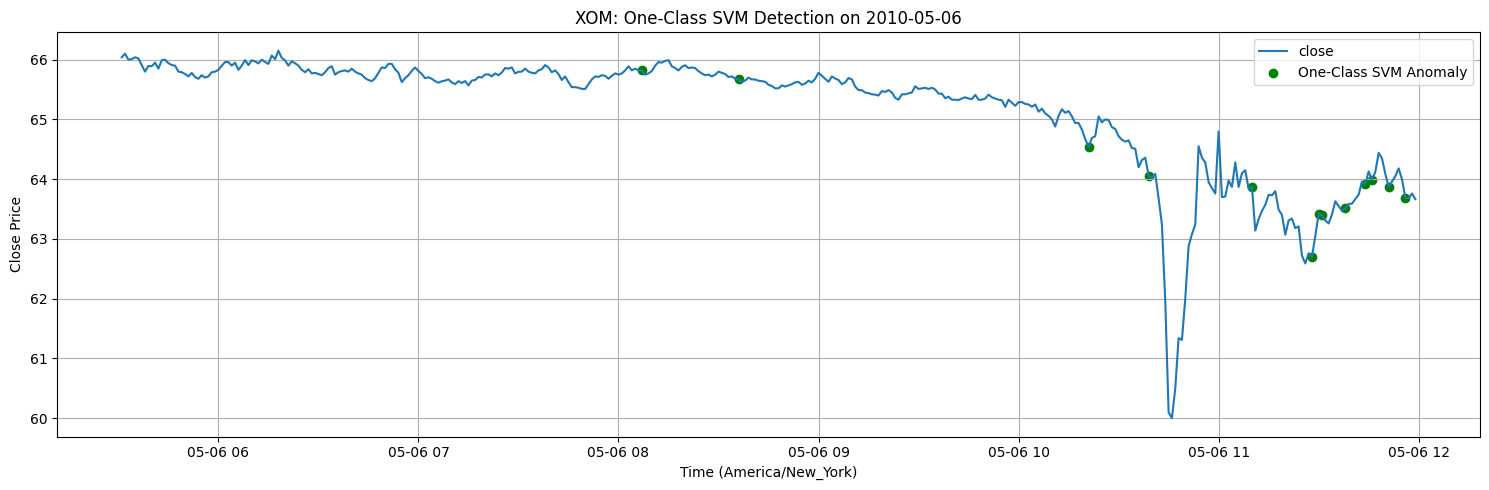

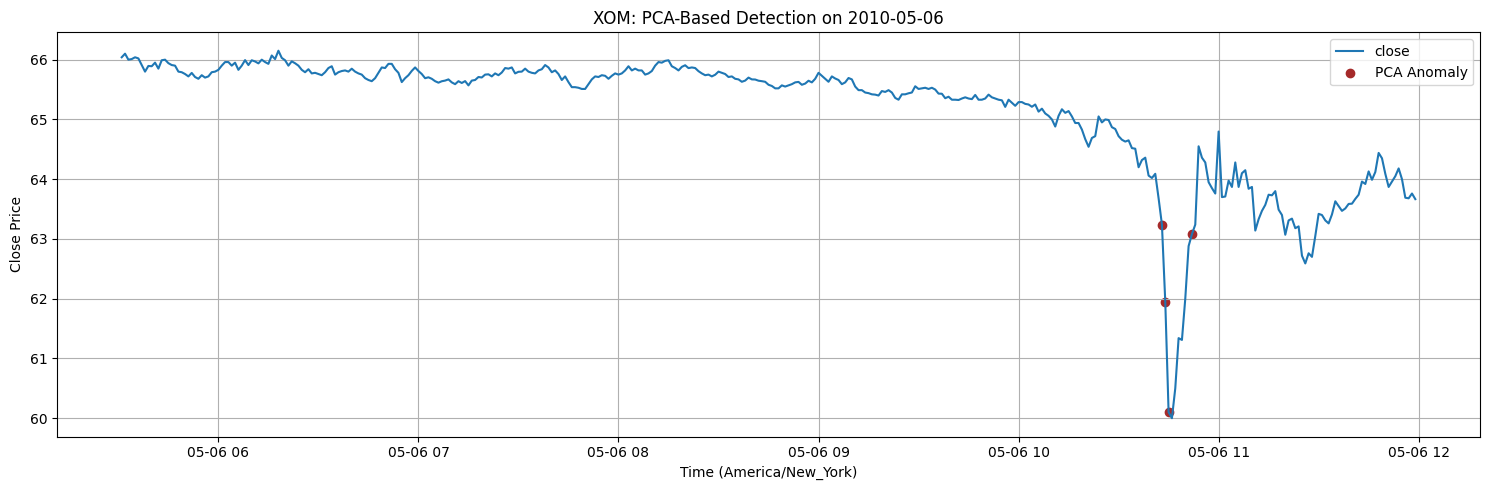


--- Comparison for XOM on 2010-05-06 ---
Threshold: Flash Crash Day = 0, Average = 0.00
Z-Score: Flash Crash Day = 3, Average = 1.26
Volume Imbalance: Flash Crash Day = 25, Average = 13.84
CUSUM: Flash Crash Day = 31, Average = 0.00
Isolation Forest: Flash Crash Day = 4, Average = 4.00
Local Outlier Factor: Flash Crash Day = 4, Average = 4.00
One-Class SVM: Flash Crash Day = 13, Average = 17.05
PCA: Flash Crash Day = 4, Average = 4.00


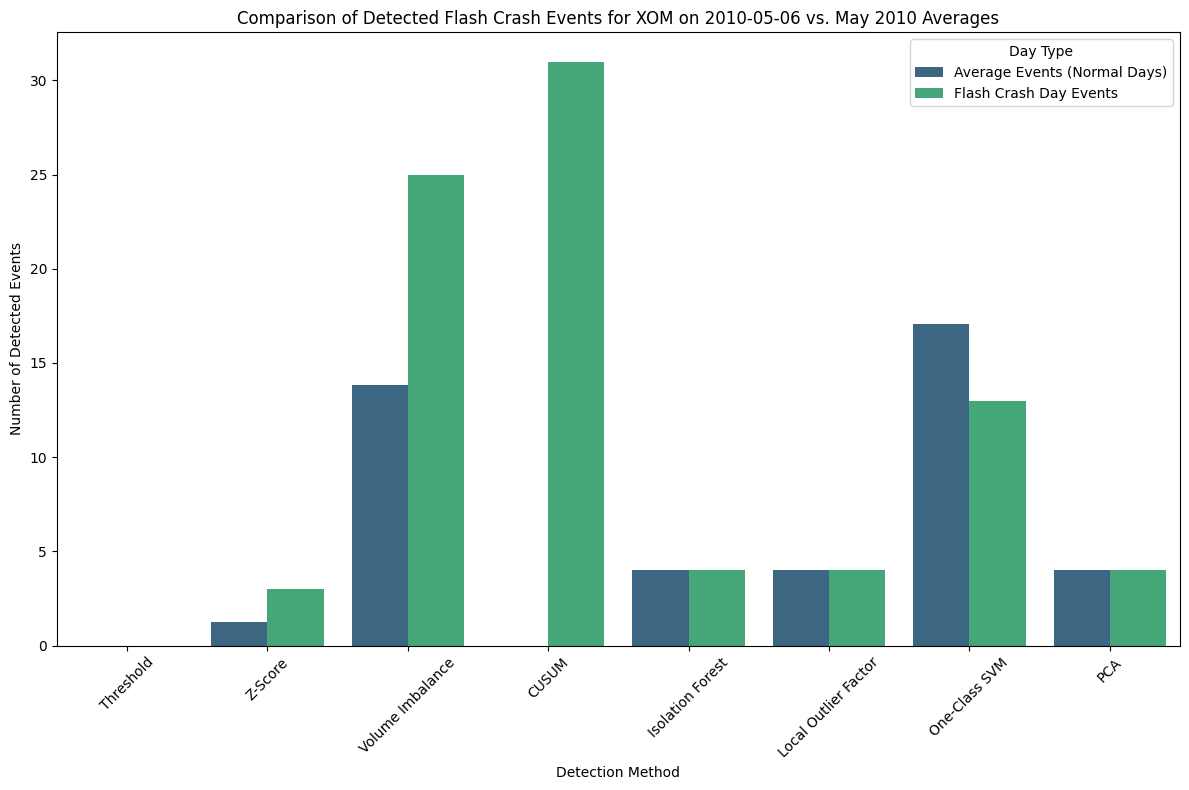


=== Flash Crash Detection for CTL in May 2010 ===

Data for CTL:
   trade_price  trade_volume                  timestamp  bid_price  bid_size  \
0        34.27         100.0 2010-05-03 09:30:16.307000      34.26      10.0   
1        34.30       19800.0 2010-05-03 09:30:16.617999      34.28       3.0   
2        34.30         150.0 2010-05-03 09:30:16.701999      34.28       3.0   
3        34.30         300.0 2010-05-03 09:30:16.701999      34.28       3.0   
4        34.30         234.0 2010-05-03 09:30:16.746000      34.28       3.0   

   ask_price  ask_size  mid_price  spread  delta_bid  delta_ask   ofi  \
0      34.35       1.0     34.305    0.09       0.01       0.03  0.07   
1      34.31      18.0     34.295    0.03       0.02      -0.04  0.78   
2      34.36       1.0     34.320    0.08       0.00       0.05 -0.05   
3      34.36       1.0     34.320    0.08       0.00       0.00  0.00   
4      34.36       1.0     34.320    0.08       0.00       0.00  0.00   

         date 

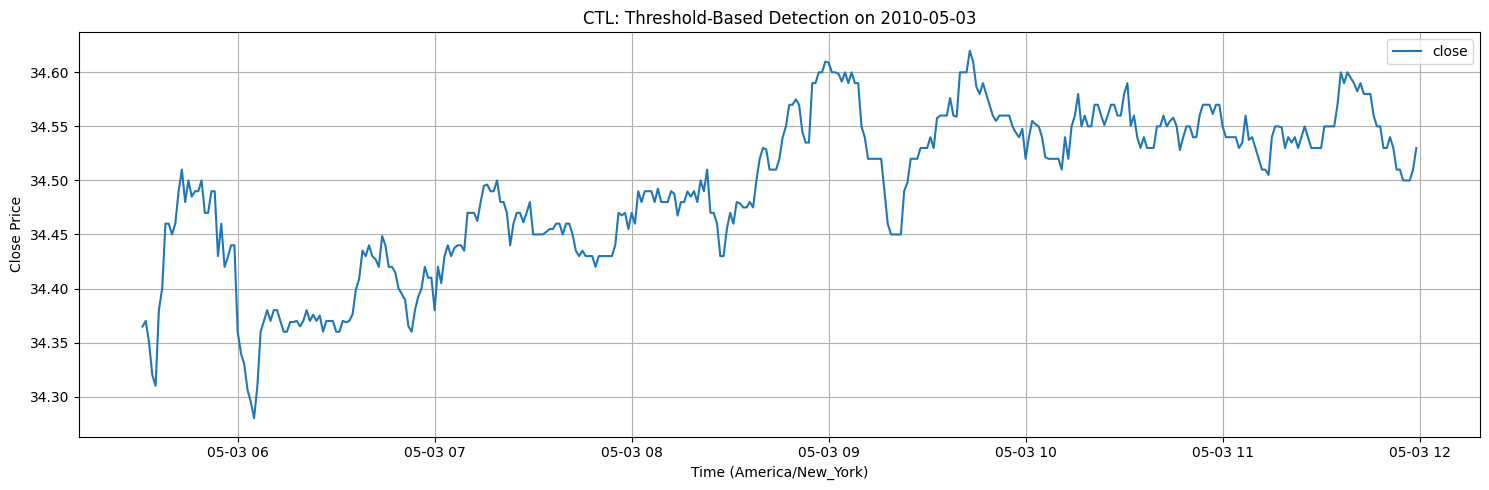

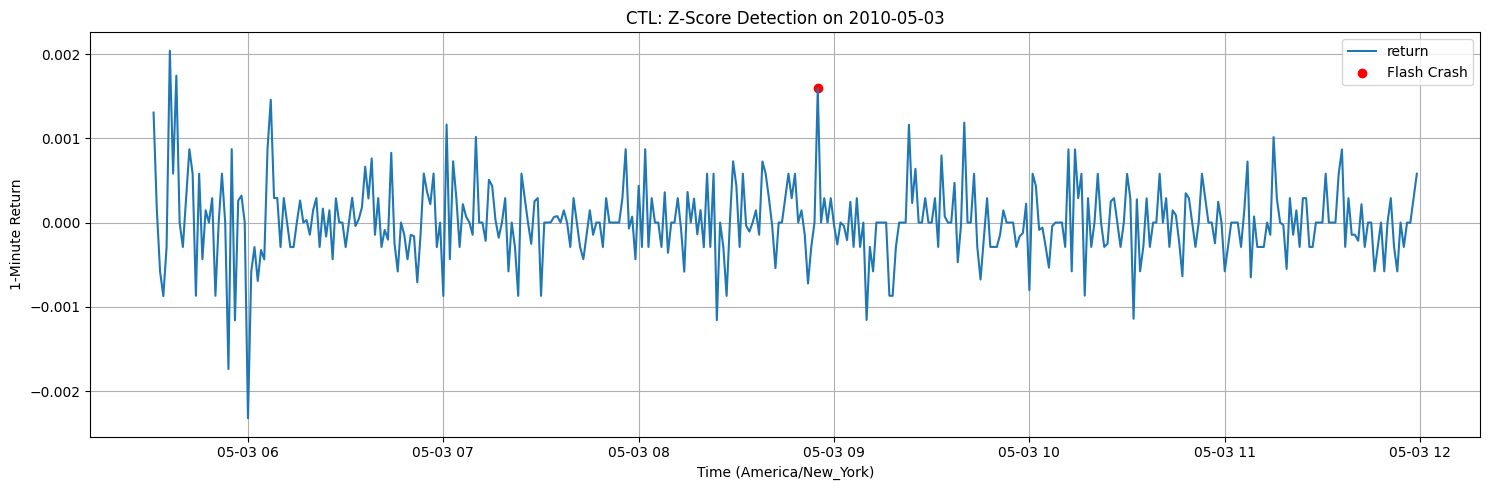

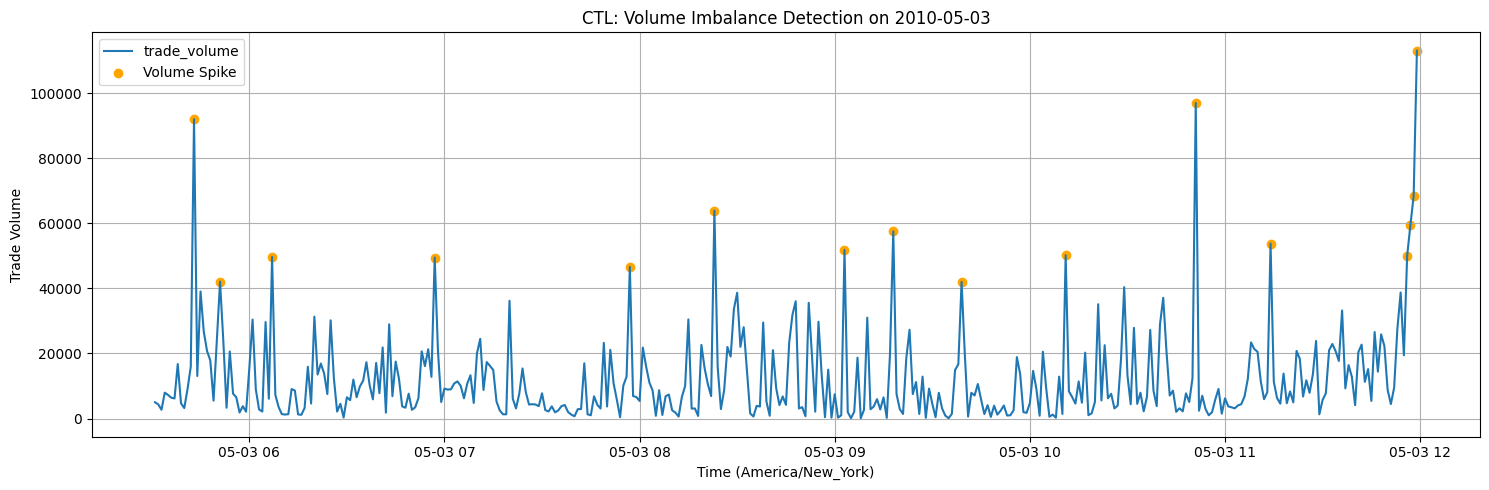

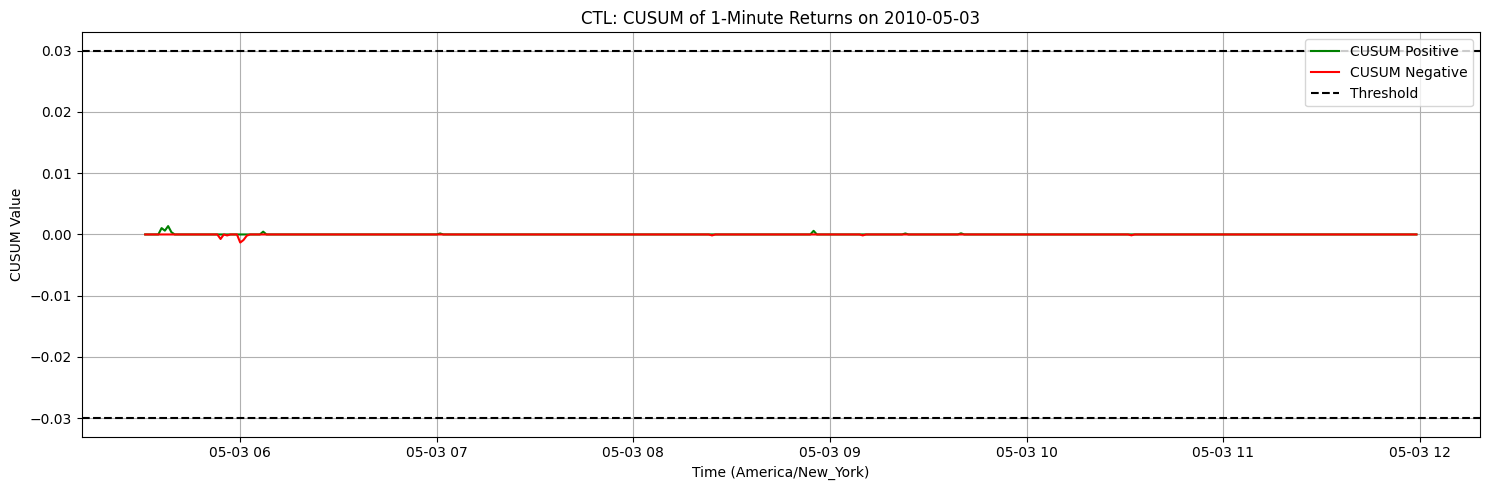

No events to plot for CTL: CUSUM Detection on 2010-05-03.


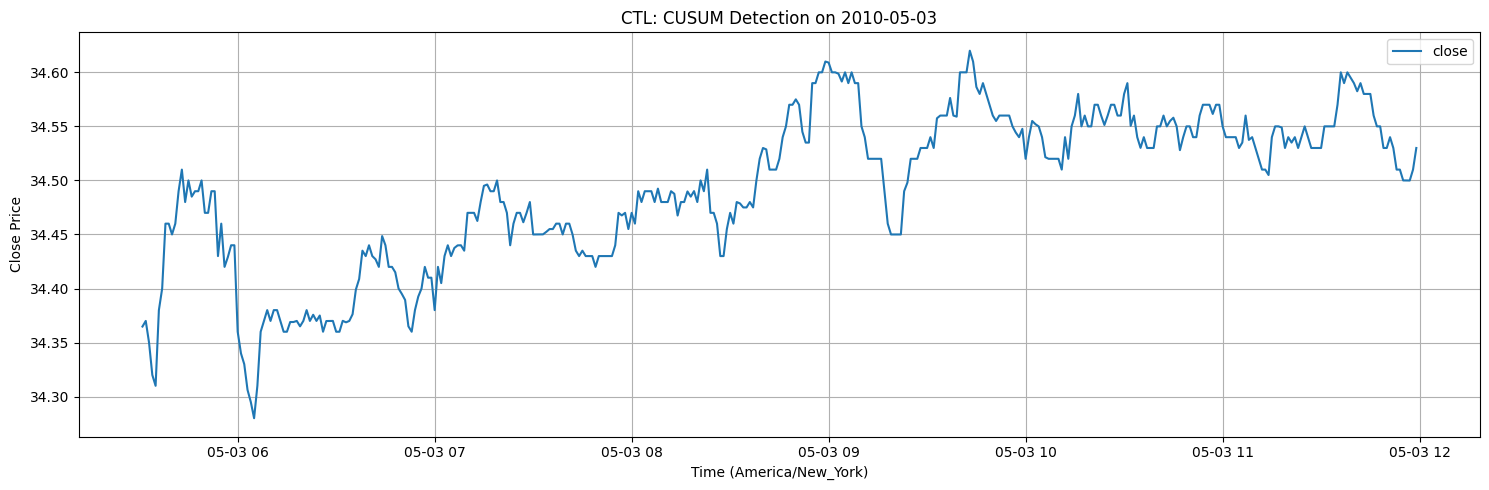

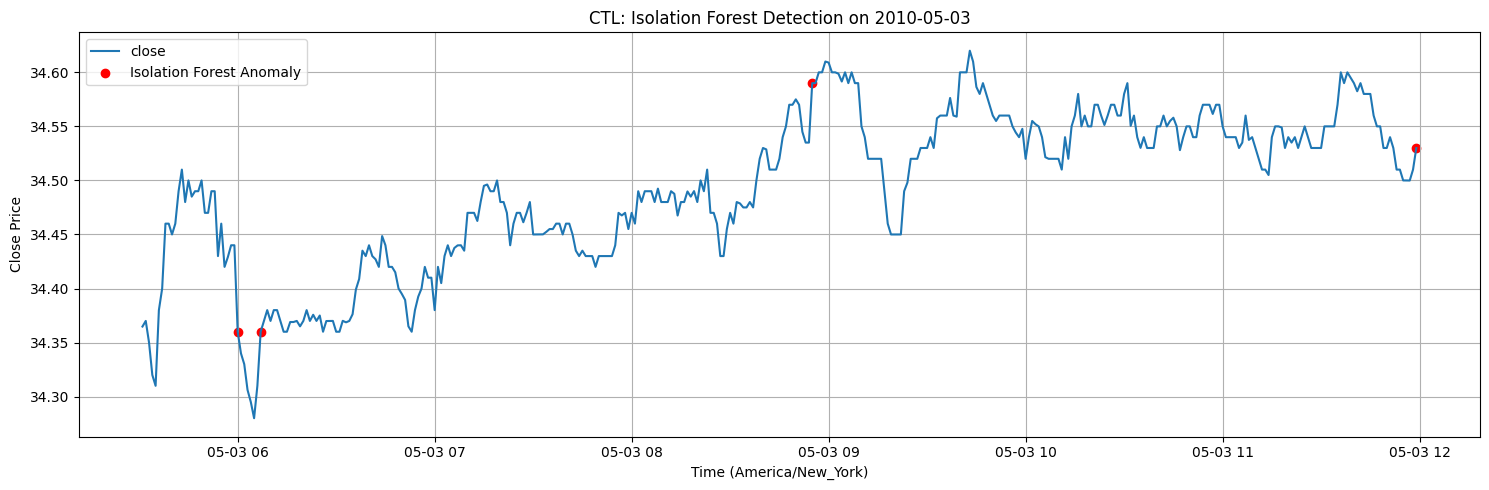

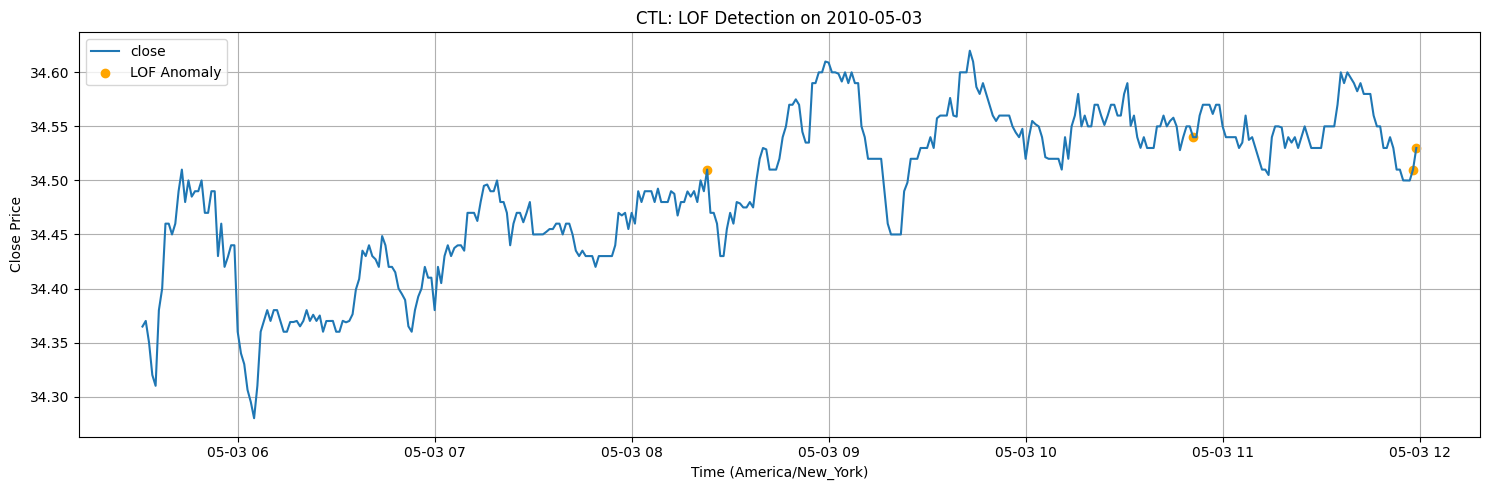

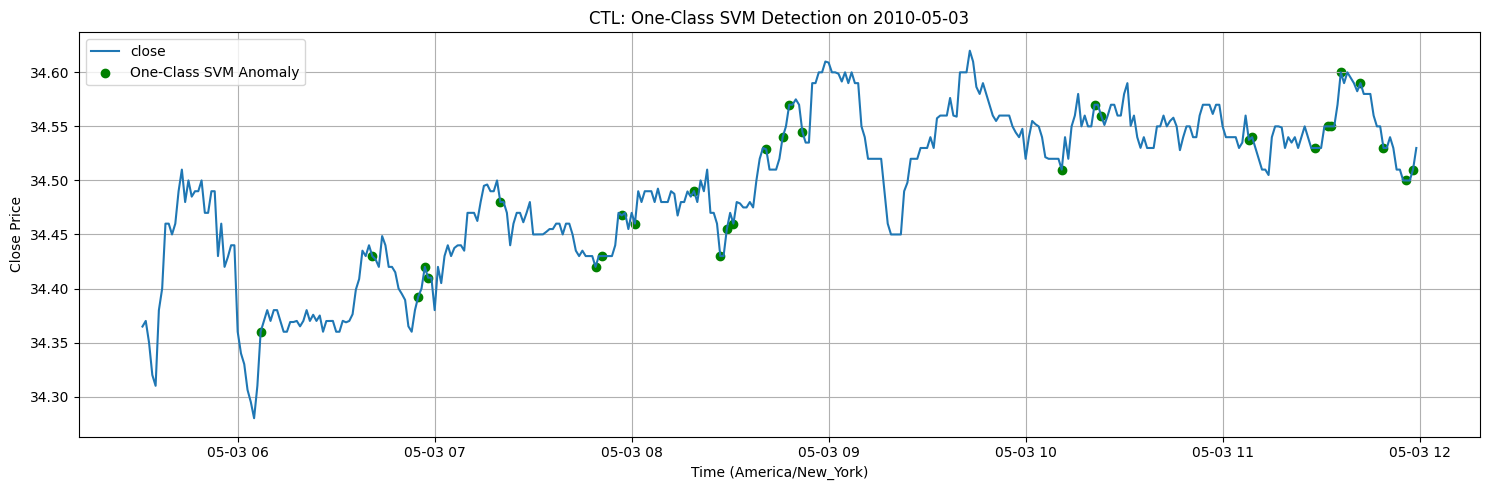

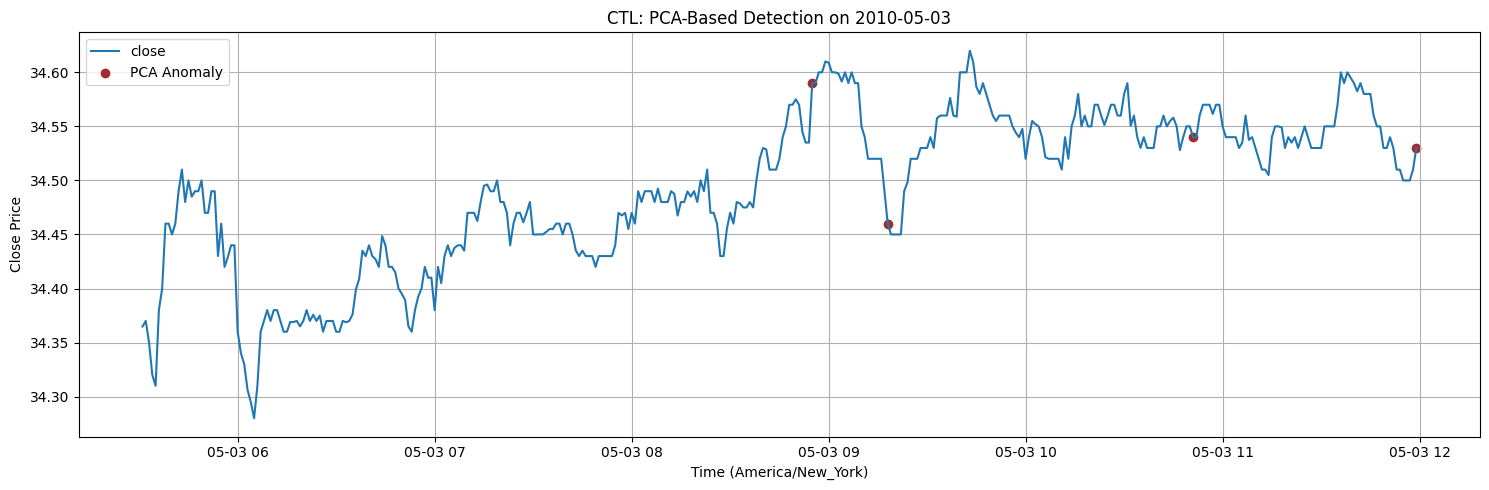


--- Average Detected Events Across 19 Normal Days ---
Threshold: 0.00
Z-Score: 2.11
Volume Imbalance: 16.42
CUSUM: 0.00
Isolation Forest: 4.00
Local Outlier Factor: 4.00
One-Class SVM: 15.53
PCA: 4.00


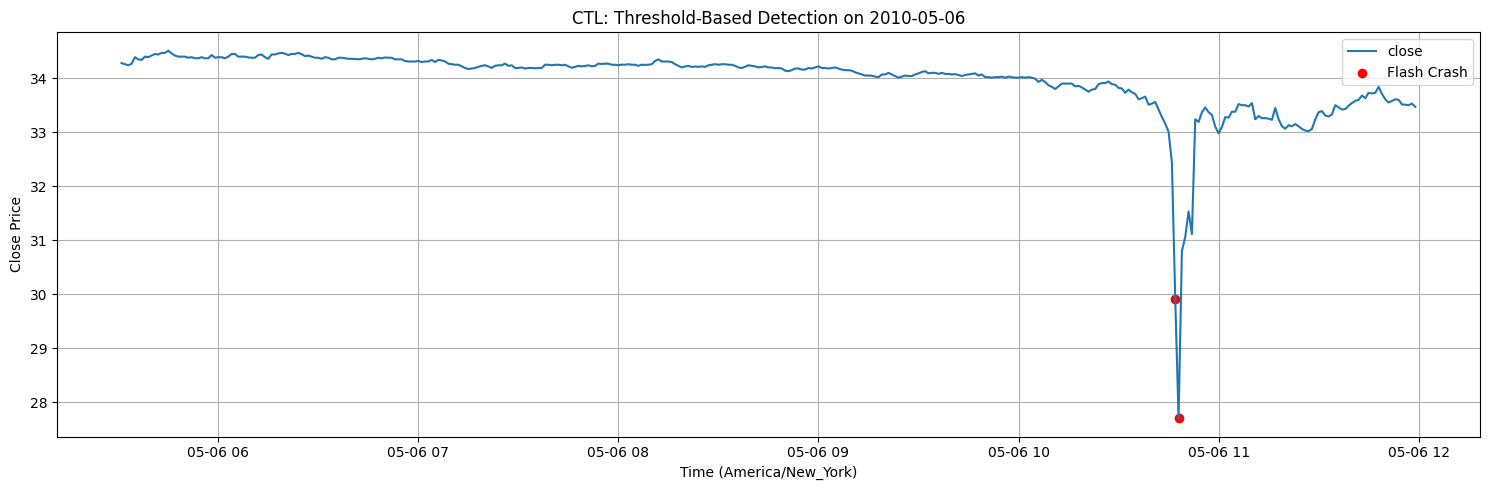

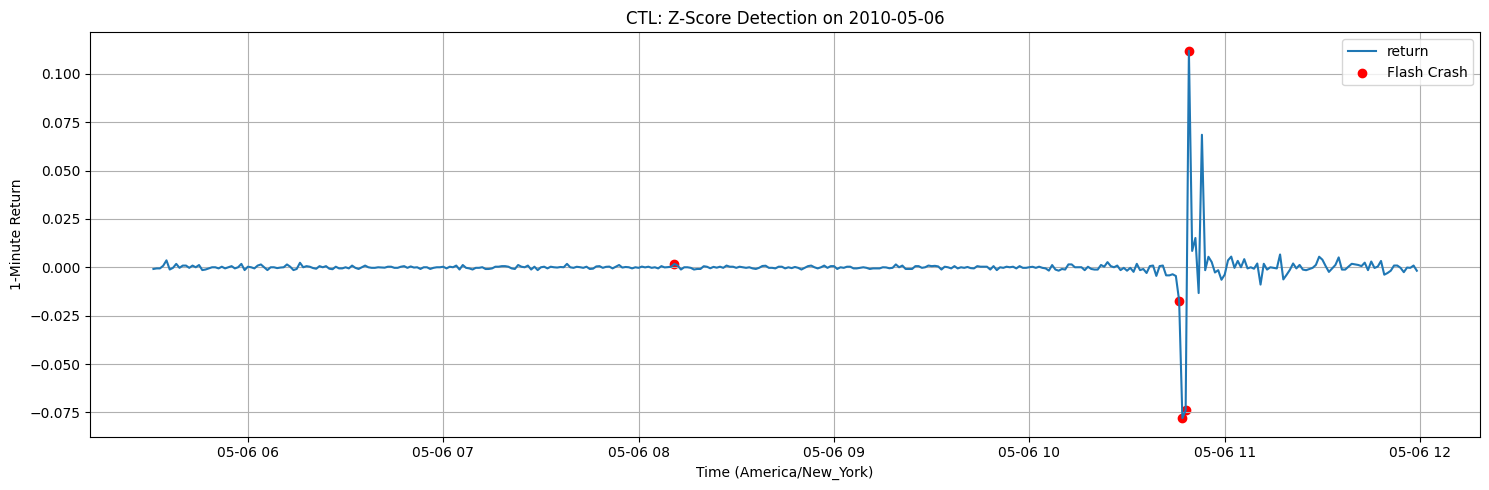

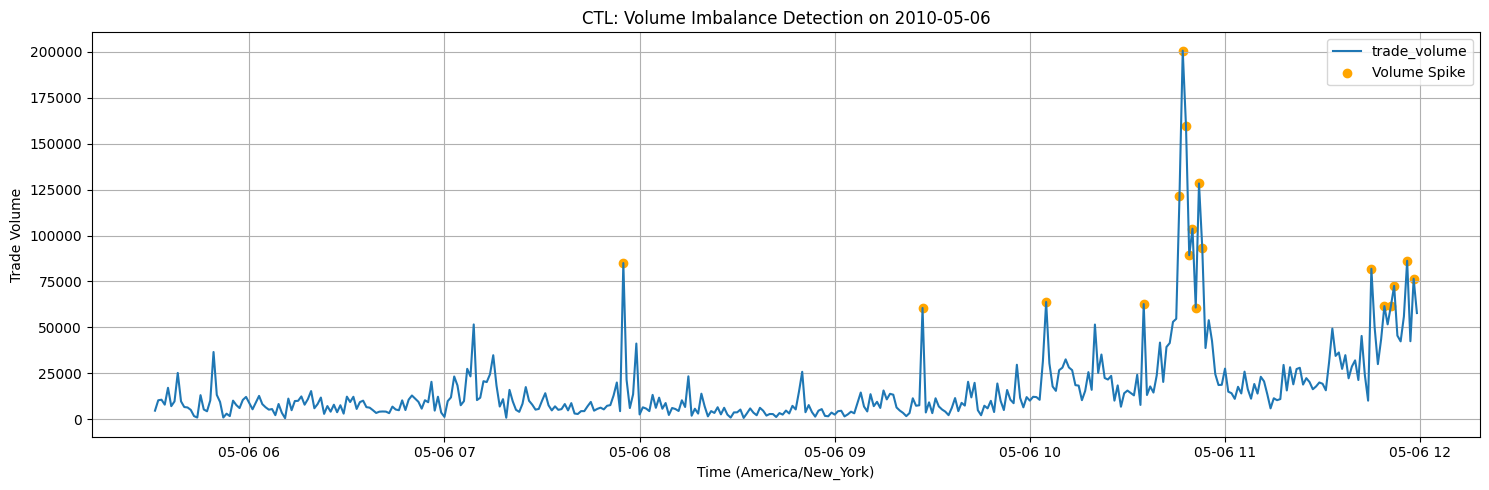

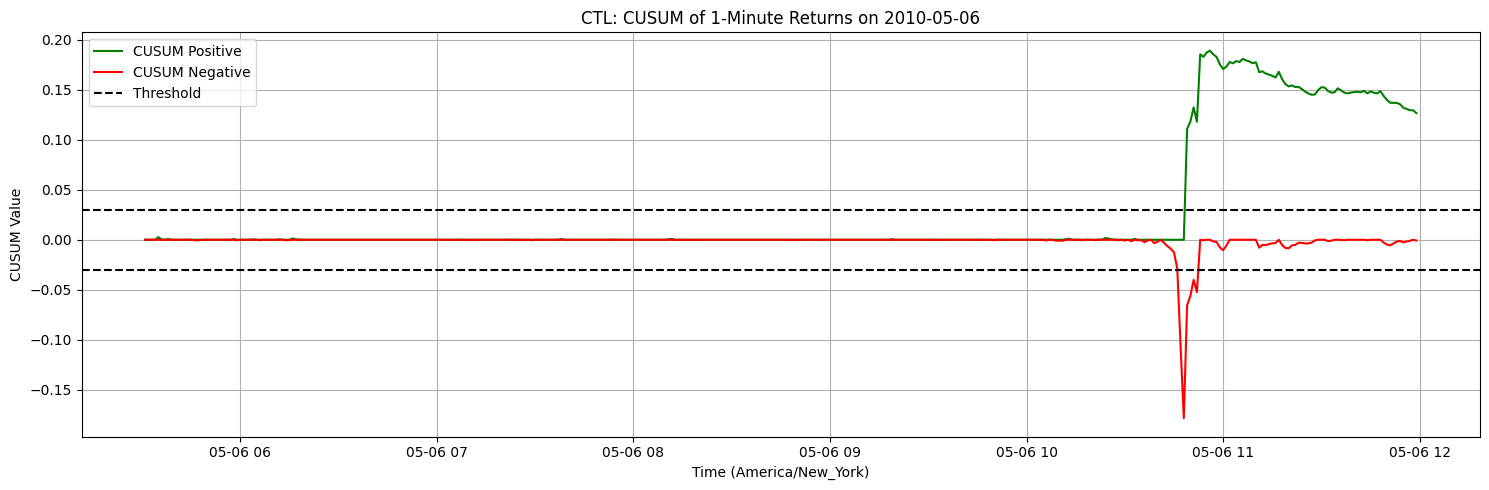

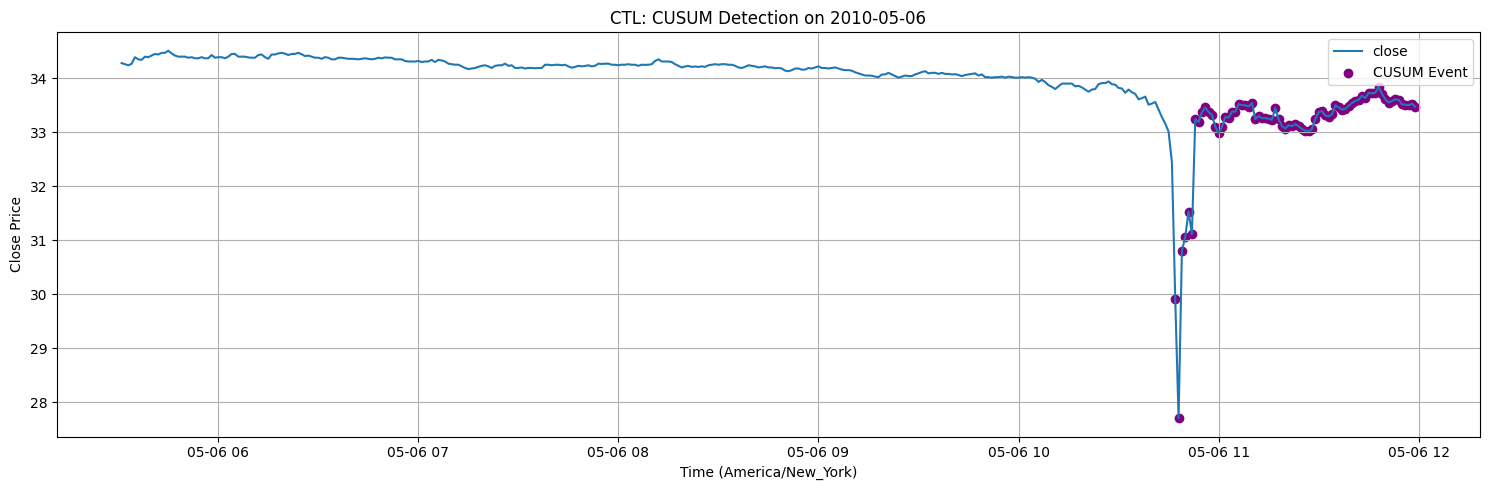

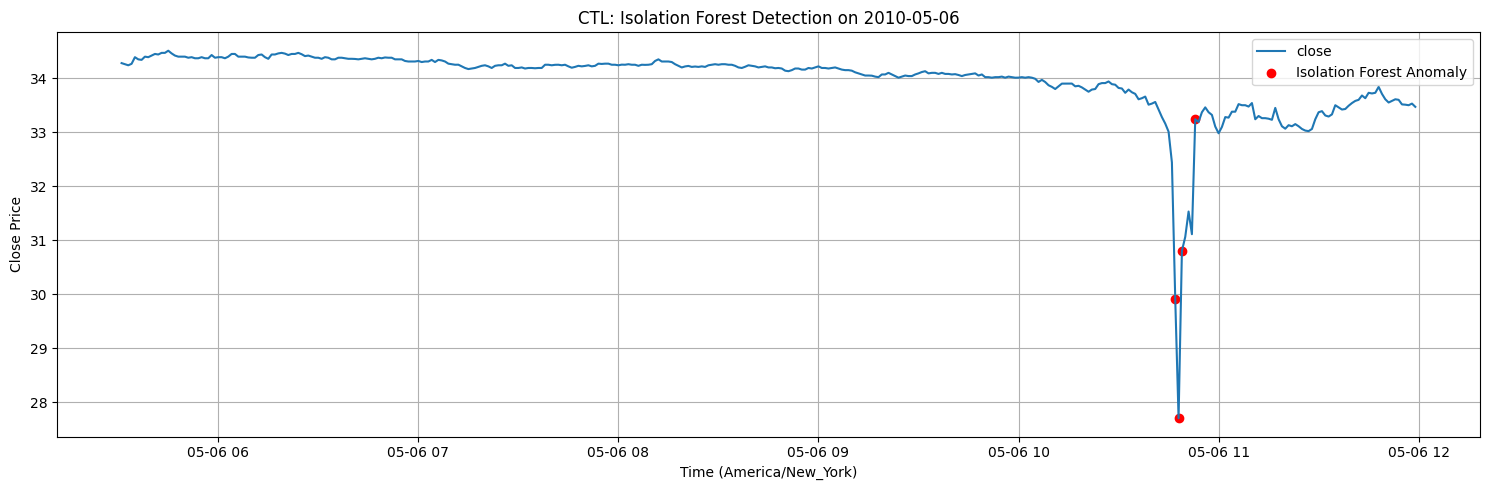

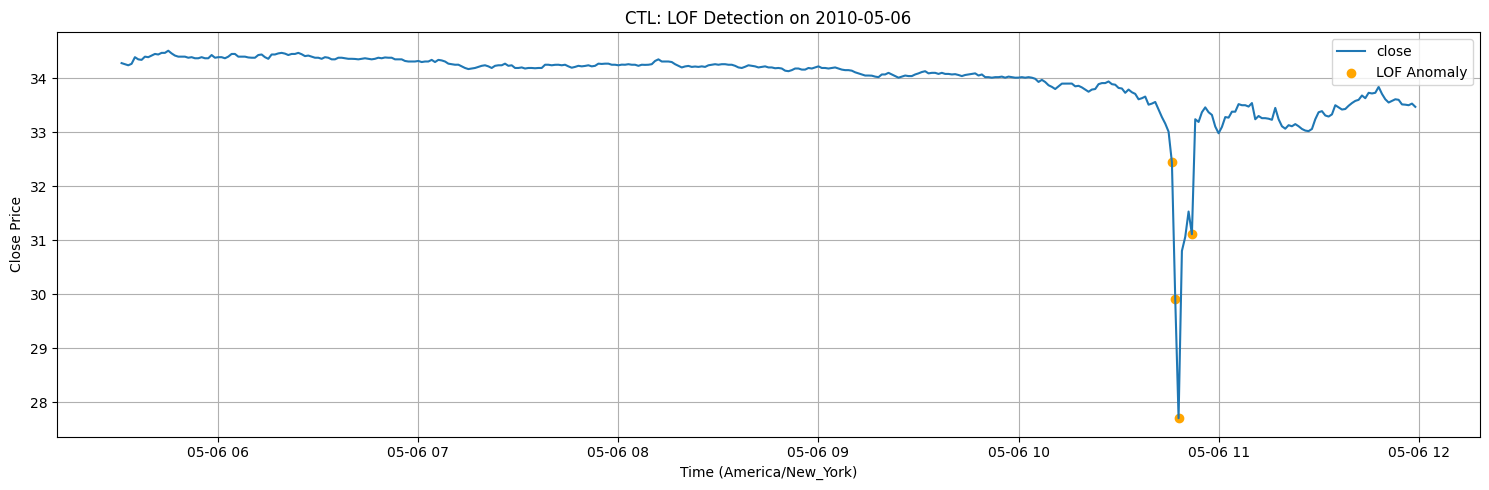

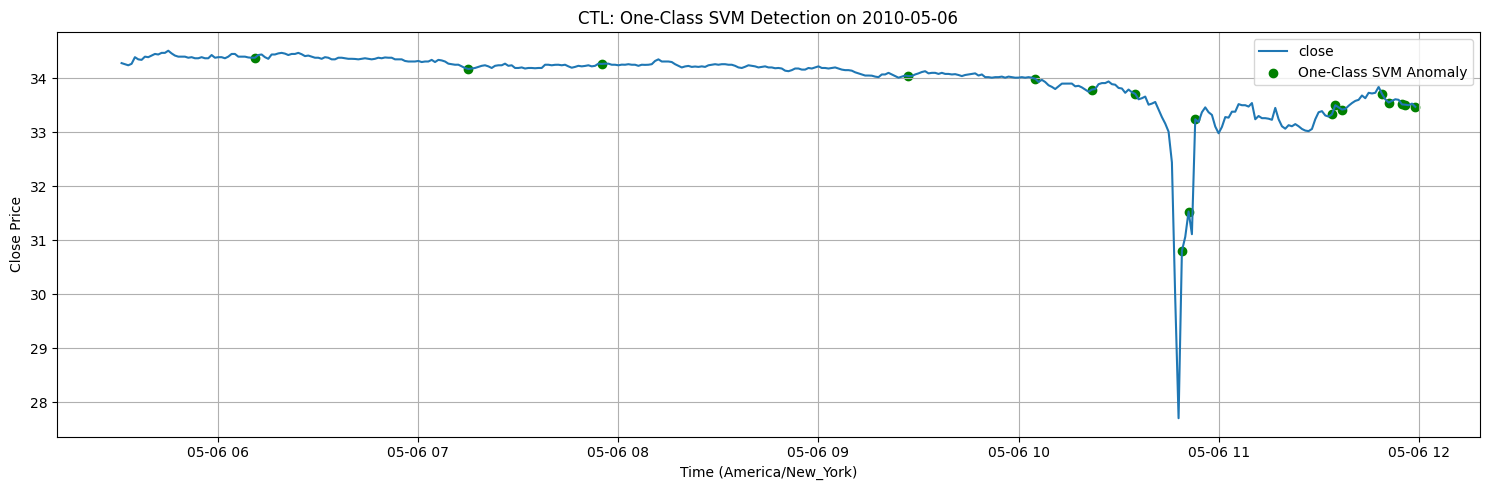

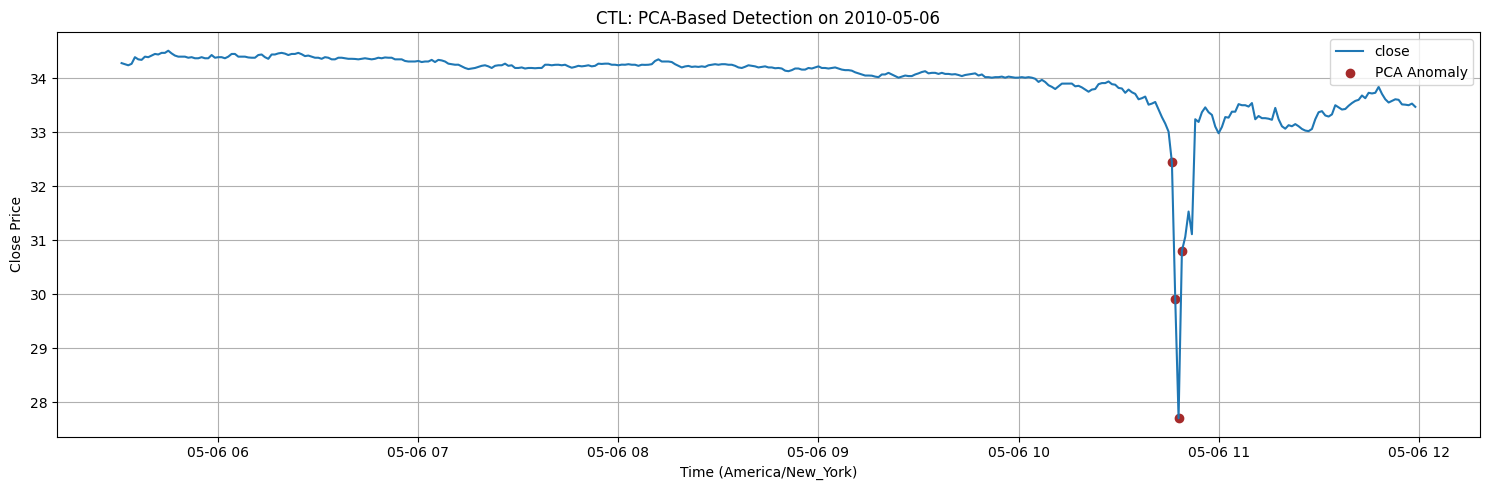


--- Comparison for CTL on 2010-05-06 ---
Threshold: Flash Crash Day = 2, Average = 0.00
Z-Score: Flash Crash Day = 5, Average = 2.11
Volume Imbalance: Flash Crash Day = 18, Average = 16.42
CUSUM: Flash Crash Day = 73, Average = 0.00
Isolation Forest: Flash Crash Day = 4, Average = 4.00
Local Outlier Factor: Flash Crash Day = 4, Average = 4.00
One-Class SVM: Flash Crash Day = 18, Average = 15.53
PCA: Flash Crash Day = 4, Average = 4.00


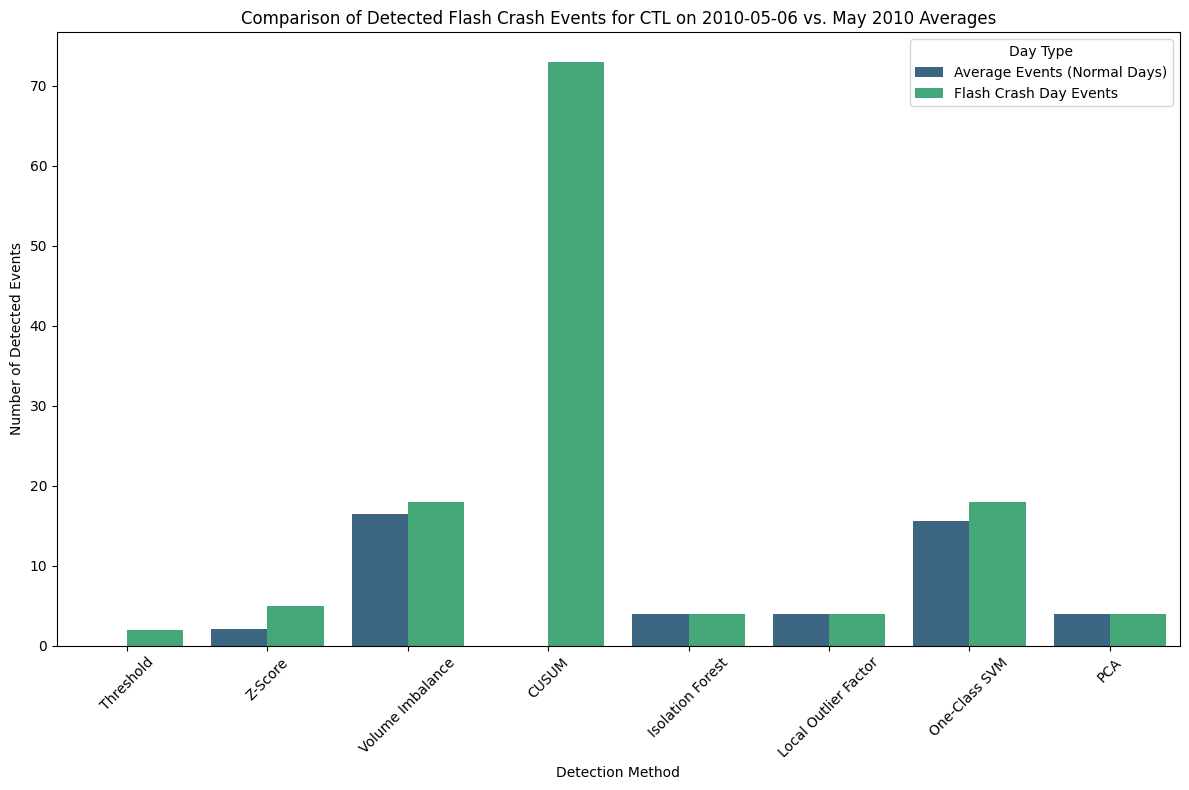

In [1]:
# ======================================================================
# IMPORTS
# ======================================================================
import os
import warnings
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings("ignore")

# ======================================================================
# CONFIGURATION
# ======================================================================
BASE_DIR = "SP500_2010_extracted"  # Change this to your data directory

# Define all trading days in May 2010
TRADING_DATES_MAY_2010 = [
    "2010-05-03", "2010-05-04", "2010-05-05",
    "2010-05-06",  # Flash Crash Day
    "2010-05-07", "2010-05-10", "2010-05-11",
    "2010-05-12", "2010-05-13", "2010-05-14",
    "2010-05-17", "2010-05-18", "2010-05-19",
    "2010-05-20", "2010-05-21", "2010-05-24",
    "2010-05-25", "2010-05-26", "2010-05-27",
    "2010-05-28"
]

FLASH_CRASH_DATE = "2010-05-06"
NORMAL_DAYS_MAY_2010 = [date for date in TRADING_DATES_MAY_2010 if date != FLASH_CRASH_DATE]

TICKERS_OF_INTEREST = ["XOM", "CTL"]  # Add more tickers if needed

# Numeric columns to force to Float64 (adjust as needed)
FORCED_NUMERIC_COLS = [
    "trade_price", "trade_volume",
    "bid_price", "bid_size",
    "ask_price", "ask_size",
    # Add other columns if needed: e.g., "mid_price", "spread", etc.
]

# ======================================================================
# HELPER FUNCTIONS: Data Loading & Filtering using Polars
# ======================================================================
def find_processed_files(base_dir: str):
    """
    Yields full paths to all files ending with '-processed.csv' in subfolders.
    """
    for subfolder in os.listdir(base_dir):
        sub_path = os.path.join(base_dir, subfolder)
        if not os.path.isdir(sub_path):
            continue
        proc_dir = os.path.join(sub_path, "processed")
        if not os.path.isdir(proc_dir):
            continue
        for fname in os.listdir(proc_dir):
            if fname.endswith("-processed.csv"):
                yield os.path.join(proc_dir, fname)

def parse_ticker_date_from_filename(fname: str):
    """
    Expects a filename such as '2010-05-06-XOM-processed.csv'
    Returns (date_str, ticker) or (None, None) if format is incorrect.
    """
    base = os.path.basename(fname)
    parts = base.split("-")
    if len(parts) < 5:
        return None, None
    date_str = "-".join(parts[0:3])
    ticker = parts[3]
    return date_str, ticker

def process_single_file(csv_path: str) -> pl.DataFrame:
    """
    Opens one CSV file with forced dtypes, adds date and ticker columns.
    Returns a Polars DataFrame only if the file corresponds to a ticker and date of interest.
    """
    date_str, ticker = parse_ticker_date_from_filename(csv_path)
    if not date_str or not ticker:
        return pl.DataFrame()
    if ticker not in TICKERS_OF_INTEREST:
        return pl.DataFrame()
    # Check if date is one of the specified dates
    if date_str not in TRADING_DATES_MAY_2010:
        return pl.DataFrame()
    
    dtype_map = {col: pl.Float64 for col in FORCED_NUMERIC_COLS}
    try:
        lf = pl.scan_csv(csv_path, has_header=True, schema_overrides=dtype_map, ignore_errors=True)
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return pl.DataFrame()
    
    lf = lf.with_columns([
        pl.lit(date_str).alias("date"),
        pl.lit(ticker).alias("ticker")
    ])
    df = lf.collect()
    if "timestamp" in df.columns:
        df = df.with_columns(pl.col("timestamp").str.to_datetime(strict=False))\
               .drop_nulls(subset=["timestamp"])
    return df.sort(["ticker", "date", "timestamp"])

def get_dates_df(df_list: list, ticker: str, dates: list) -> pl.DataFrame:
    """
    Concatenates a list of Polars DataFrames and filters to specific ticker and dates.
    """
    if not df_list:
        return pl.DataFrame()
    df_combined = pl.concat(df_list, how="vertical")
    return df_combined.filter(
        (pl.col("ticker") == ticker) &
        (pl.col("date").is_in(dates))
    ).sort("timestamp")

# ======================================================================
# HELPER FUNCTIONS: Flash Crash Detection Specific
# ======================================================================
def plot_time_series(df, column, title, ylabel, save_path=None):
    """
    Plots a time series for a specified column.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[column], label=column)
    plt.xlabel("Time (America/New_York)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    plt.close()

def plot_events(df, event_times, column, title, ylabel, color='red', label='Flash Crash'):
    """
    Plots the main time series and overlays detected event points.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[column], label=column)
    if not event_times.empty:
        plt.scatter(event_times, df.loc[event_times, column], color=color, label=label)
    else:
        print(f"No events to plot for {title}.")
    plt.xlabel("Time (America/New_York)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

def isolation_forest_anomaly_detection(df_features, contamination=0.01):
    """
    Apply the Isolation Forest anomaly detection algorithm on a DataFrame of features.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df_features['anomaly'] = iso_forest.fit_predict(df_features)
    return df_features

def local_outlier_factor_detection(df_features, contamination=0.01):
    """
    Apply the Local Outlier Factor (LOF) anomaly detection.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    anomaly_labels = lof.fit_predict(df_features)
    df_features['anomaly'] = anomaly_labels
    return df_features

def one_class_svm_anomaly_detection(df_features, contamination=0.01):
    """
    Apply the One-Class SVM anomaly detection algorithm.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    svm = OneClassSVM(nu=contamination, kernel="rbf", gamma='scale')
    svm.fit(df_features)
    anomaly_labels = svm.predict(df_features)
    df_features['anomaly'] = anomaly_labels
    return df_features

def pca_anomaly_detection(df_features, contamination=0.01, n_components=2):
    """
    Apply PCA for dimensionality reduction followed by Isolation Forest for anomaly detection.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    pca = PCA(n_components=n_components, random_state=42)
    principal_components = pca.fit_transform(df_features)
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomaly_labels = iso_forest.fit_predict(principal_components)
    df_features['anomaly'] = anomaly_labels
    return df_features

# ======================================================================
# HELPER FUNCTION: Apply Detection Methods
# ======================================================================
def apply_detection_methods(df_target, ticker, day_label):
    """
    Applies various flash crash detection methods on the target DataFrame.
    Returns a dictionary with counts of detected events per method.
    Only plots for 2010-05-03 and 2010-05-06.
    """
    method_event_counts = {}  # Dictionary to store counts per method

    # 1. Threshold-Based Detection
    threshold = -0.03  # 3% drop
    threshold_events = df_target[df_target['return'] < threshold]
    method_event_counts['Threshold'] = len(threshold_events)
    if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
        plot_events(df_target, threshold_events.index, 'close',
                    f"{ticker}: Threshold-Based Detection on {day_label}",
                    "Close Price")

    # 2. Volatility Z-Score Detection
    window = 30  # 30-minute rolling window
    z_threshold = 3.0
    rolling_mean = df_target['return'].rolling(window=window).mean()
    rolling_std = df_target['return'].rolling(window=window).std()
    z_scores = (df_target['return'] - rolling_mean) / rolling_std
    df_target['z_score'] = z_scores
    z_events = df_target[abs(df_target['z_score']) > z_threshold]
    method_event_counts['Z-Score'] = len(z_events)
    if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
        plot_events(df_target, z_events.index, 'return',
                    f"{ticker}: Z-Score Detection on {day_label}",
                    "1-Minute Return")

    # 3. Volume Imbalance Detection
    vol_mean = df_target['trade_volume'].mean()
    vol_std = df_target['trade_volume'].std()
    vol_threshold = vol_mean + 2 * vol_std  # Mean + 2*Std
    vol_spikes = df_target[df_target['trade_volume'] > vol_threshold]
    method_event_counts['Volume Imbalance'] = len(vol_spikes)
    if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
        plot_events(df_target, vol_spikes.index, 'trade_volume',
                    f"{ticker}: Volume Imbalance Detection on {day_label}",
                    "Trade Volume", color='orange', label='Volume Spike')

    # 4. CUSUM Detection
    def cusum_detection(df_returns, threshold=0.03, drift=0.001):
        """
        Apply a simple CUSUM algorithm to a return series.
        Returns cumulative sums and boolean series indicating when the threshold is exceeded.
        """
        s_pos = np.zeros(len(df_returns))
        s_neg = np.zeros(len(df_returns))
        pos_alert = np.zeros(len(df_returns), dtype=bool)
        neg_alert = np.zeros(len(df_returns), dtype=bool)
        
        for i in range(1, len(df_returns)):
            s_pos[i] = max(0, s_pos[i-1] + df_returns.iloc[i] - drift)
            s_neg[i] = min(0, s_neg[i-1] + df_returns.iloc[i] + drift)
            if s_pos[i] > threshold:
                pos_alert[i] = True
            if s_neg[i] < -threshold:
                neg_alert[i] = True
        return s_pos, s_neg, pos_alert, neg_alert

    returns_1min = df_target['return']
    s_pos, s_neg, pos_alert, neg_alert = cusum_detection(returns_1min, threshold=0.03, drift=0.001)
    
    # Assign CUSUM values directly without inserting NaN
    df_target['CUSUM_Pos'] = pd.Series(s_pos, index=df_target.index)
    df_target['CUSUM_Neg'] = pd.Series(s_neg, index=df_target.index)
    
    if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
        plt.figure(figsize=(15, 5))
        plt.plot(df_target.index, df_target['CUSUM_Pos'], label="CUSUM Positive", color='green')
        plt.plot(df_target.index, df_target['CUSUM_Neg'], label="CUSUM Negative", color='red')
        plt.axhline(0.03, color='black', linestyle='--', label="Threshold")
        plt.axhline(-0.03, color='black', linestyle='--')
        plt.xlabel("Time (America/New_York)")
        plt.ylabel("CUSUM Value")
        plt.title(f"{ticker}: CUSUM of 1-Minute Returns on {day_label}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()
    
    # Identify CUSUM Events
    cusum_alerts = df_target[(df_target['CUSUM_Pos'] > 0.03) | (df_target['CUSUM_Neg'] < -0.03)]
    method_event_counts['CUSUM'] = len(cusum_alerts)
    if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
        plot_events(df_target, cusum_alerts.index, 'close',
                    f"{ticker}: CUSUM Detection on {day_label}",
                    "Close Price", color='purple', label='CUSUM Event')

    # 5. Unsupervised Learning Methods
    df_features = pd.DataFrame({
        'return': df_target['return'],
        'trade_volume': df_target['trade_volume'],
        'z_score': df_target['z_score']
    }).dropna()
    
    if not df_features.empty:
        # 5.1 Isolation Forest
        df_if = isolation_forest_anomaly_detection(df_features.copy(), contamination=0.01)
        if_anomalies = df_if[df_if['anomaly'] == -1]
        method_event_counts['Isolation Forest'] = len(if_anomalies)
        if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
            plot_events(df_target, if_anomalies.index, 'close',
                        f"{ticker}: Isolation Forest Detection on {day_label}",
                        "Close Price", color='red', label='Isolation Forest Anomaly')

        # 5.2 Local Outlier Factor (LOF)
        df_lof = local_outlier_factor_detection(df_features.copy(), contamination=0.01)
        lof_anomalies = df_lof[df_lof['anomaly'] == -1]
        method_event_counts['Local Outlier Factor'] = len(lof_anomalies)
        if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
            plot_events(df_target, lof_anomalies.index, 'close',
                        f"{ticker}: LOF Detection on {day_label}",
                        "Close Price", color='orange', label='LOF Anomaly')

        # 5.3 One-Class SVM
        df_svm = one_class_svm_anomaly_detection(df_features.copy(), contamination=0.01)
        svm_anomalies = df_svm[df_svm['anomaly'] == -1]
        method_event_counts['One-Class SVM'] = len(svm_anomalies)
        if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
            plot_events(df_target, svm_anomalies.index, 'close',
                        f"{ticker}: One-Class SVM Detection on {day_label}",
                        "Close Price", color='green', label='One-Class SVM Anomaly')

        # 5.4 Principal Component Analysis (PCA) for Anomaly Detection
        df_pca = pca_anomaly_detection(df_features.copy(), contamination=0.01, n_components=2)
        pca_anomalies = df_pca[df_pca['anomaly'] == -1]
        method_event_counts['PCA'] = len(pca_anomalies)
        if day_label in ["2010-05-03", FLASH_CRASH_DATE]:
            plot_events(df_target, pca_anomalies.index, 'close',
                        f"{ticker}: PCA-Based Detection on {day_label}",
                        "Close Price", color='brown', label='PCA Anomaly')
    else:
        # Add zero counts for unsupervised methods if no features are available
        method_event_counts['Isolation Forest'] = 0
        method_event_counts['Local Outlier Factor'] = 0
        method_event_counts['One-Class SVM'] = 0
        method_event_counts['PCA'] = 0

    return method_event_counts

# ======================================================================
# MAIN FLASH CRASH DETECTION ANALYSIS
# ======================================================================
def main():
    # --- Data Loading ---
    data_map = {}  # key: ticker, value: list of Polars DataFrames
    for csv_path in find_processed_files(BASE_DIR):
        df = process_single_file(csv_path)
        if df.is_empty():
            continue
        unique_tickers = df.select(pl.col("ticker")).unique().to_series().to_list()
        unique_dates = df.select(pl.col("date")).unique().to_series().to_list()
        for tkr in unique_tickers:
            for dt in unique_dates:
                subset_df = df.filter((pl.col("ticker") == tkr) & (pl.col("date") == dt))
                data_map.setdefault(tkr, []).append(subset_df)
    
    # --- Flash Crash Detection for Each Ticker ---
    for ticker in TICKERS_OF_INTEREST:
        print(f"\n=== Flash Crash Detection for {ticker} in May 2010 ===")
        
        # Get all data for the ticker on the specified dates
        df_ticker_polars = data_map.get(ticker, [])
        if not df_ticker_polars:
            print(f"[WARN] No data found for {ticker} on specified dates.")
            continue
        df_dates_polars = get_dates_df(df_ticker_polars, ticker, TRADING_DATES_MAY_2010)
        
        if df_dates_polars.is_empty():
            print(f"[WARN] No data after filtering for {ticker} on specified dates.")
            continue
        
        # Convert to Pandas DataFrame
        df = df_dates_polars.to_pandas()
        
        # --- Debugging: Verify Data Loading ---
        print(f"\nData for {ticker}:")
        print(df.head())
        print(f"Total records: {len(df)}")
        
        # --- Timezone Conversion ---
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['timestamp'], inplace=True)  # Drop rows with invalid timestamps
        try:
            ny_index = pd.DatetimeIndex(df['timestamp']).tz_localize('UTC').tz_convert('America/New_York')
        except Exception as e:
            print(f"Error in timezone conversion for {ticker}: {e}")
            continue
        df.set_index(ny_index, inplace=True)
        df.drop(columns=['timestamp', 'date', 'ticker'], inplace=True)  # Drop unnecessary columns
        
        # --- Debugging: Verify Timestamp Conversion ---
        print(f"\nData after timezone conversion for {ticker}:")
        print(df.head())
        print(f"Data range: {df.index.min()} to {df.index.max()}")
        
        # --- Resampling to 1-Minute Intervals ---
        df_1min = df.resample('1min').agg({
            'trade_price': 'ohlc',
            'trade_volume': 'sum'
        })
        df_1min.columns = ['open', 'high', 'low', 'close', 'trade_volume']
        
        # Calculate 1-minute returns
        df_1min['return'] = df_1min['close'].pct_change(fill_method=None)
        
        # Drop the first row with NaN return
        df_1min.dropna(subset=['return'], inplace=True)
        
        # --- Debugging: Verify Resampled Data ---
        print(f"\nResampled 1-minute data for {ticker}:")
        print(df_1min.head())
        print(f"Total 1-minute records: {len(df_1min)}")
        
        # --- Separate Data by Date ---
        df_1min['date'] = df_1min.index.date
        flash_crash_day = pd.to_datetime(FLASH_CRASH_DATE).date()
        normal_days = [pd.to_datetime(date).date() for date in NORMAL_DAYS_MAY_2010]
        df_flash = df_1min[df_1min['date'] == flash_crash_day]
        df_normals = df_1min[df_1min['date'].isin(normal_days)]
        
        # --- Debugging: Verify Data Separation ---
        print(f"\nRecords on Flash Crash Day ({FLASH_CRASH_DATE}): {len(df_flash)}")
        print(f"Records on Normal Days: {len(df_normals)}")
        
        # Initialize a dictionary to hold cumulative event counts for normal days
        cumulative_event_counts = {
            'Threshold': 0,
            'Z-Score': 0,
            'Volume Imbalance': 0,
            'CUSUM': 0,
            'Isolation Forest': 0,
            'Local Outlier Factor': 0,
            'One-Class SVM': 0,
            'PCA': 0
        }
        normal_days_count = 0  # To compute the average later
        
        # --- Apply Detection Methods on Normal Days ---
        for day in normal_days:
            df_day = df_1min[df_1min['date'] == day]
            if df_day.empty:
                continue
            method_counts = apply_detection_methods(df_day, ticker, day.strftime("%Y-%m-%d"))
            for method, count in method_counts.items():
                cumulative_event_counts[method] += count
            normal_days_count += 1
        
        if normal_days_count > 0:
            # Calculate average counts
            average_event_counts = {method: count / normal_days_count for method, count in cumulative_event_counts.items()}
            print(f"\n--- Average Detected Events Across {normal_days_count} Normal Days ---")
            for method, avg_count in average_event_counts.items():
                print(f"{method}: {avg_count:.2f}")
        else:
            print("[WARN] No normal trading days processed. Cannot compute averages.")
            average_event_counts = {method: 0 for method in cumulative_event_counts.keys()}
        
        # --- Apply Detection Methods on Flash Crash Day ---
        if not df_flash.empty:
            method_counts_flash = apply_detection_methods(df_flash, ticker, FLASH_CRASH_DATE)
            print(f"\n--- Comparison for {ticker} on {FLASH_CRASH_DATE} ---")
            comparison_data = []
            for method in cumulative_event_counts.keys():
                flash_count = method_counts_flash.get(method, 0)
                average_count = average_event_counts.get(method, 0)
                comparison_data.append({
                    'Method': method,
                    'Average Events (Normal Days)': average_count,
                    'Flash Crash Day Events': flash_count
                })
                print(f"{method}: Flash Crash Day = {flash_count}, Average = {average_count:.2f}")
            
            # Convert comparison data to DataFrame for plotting
            df_comparison = pd.DataFrame(comparison_data)
            
            # Plot Comparison for Each Method
            df_melted = df_comparison.melt(id_vars='Method', 
                                           value_vars=['Average Events (Normal Days)', 'Flash Crash Day Events'],
                                           var_name='Day Type', value_name='Events')
            
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Method', y='Events', hue='Day Type', data=df_melted, palette='viridis')
            plt.title(f"Comparison of Detected Flash Crash Events for {ticker} on {FLASH_CRASH_DATE} vs. May 2010 Averages")
            plt.xlabel("Detection Method")
            plt.ylabel("Number of Detected Events")
            plt.legend(title='Day Type')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            plt.close()
        else:
            print(f"No data available for Flash Crash Day ({FLASH_CRASH_DATE}) for {ticker}.")

# ======================================================================
# ENTRY POINT
# ======================================================================
if __name__ == "__main__":
    main()

2025-01-24 20:13:03,123 - INFO - Scanning for processed CSV files...
2025-01-24 20:13:03,378 - INFO - Total processed files found: 7785
2025-01-24 20:13:03,391 - INFO - Total tickers to process: 392
Processing Tickers: 100%|██████████| 392/392 [49:00<00:00,  7.50s/it]


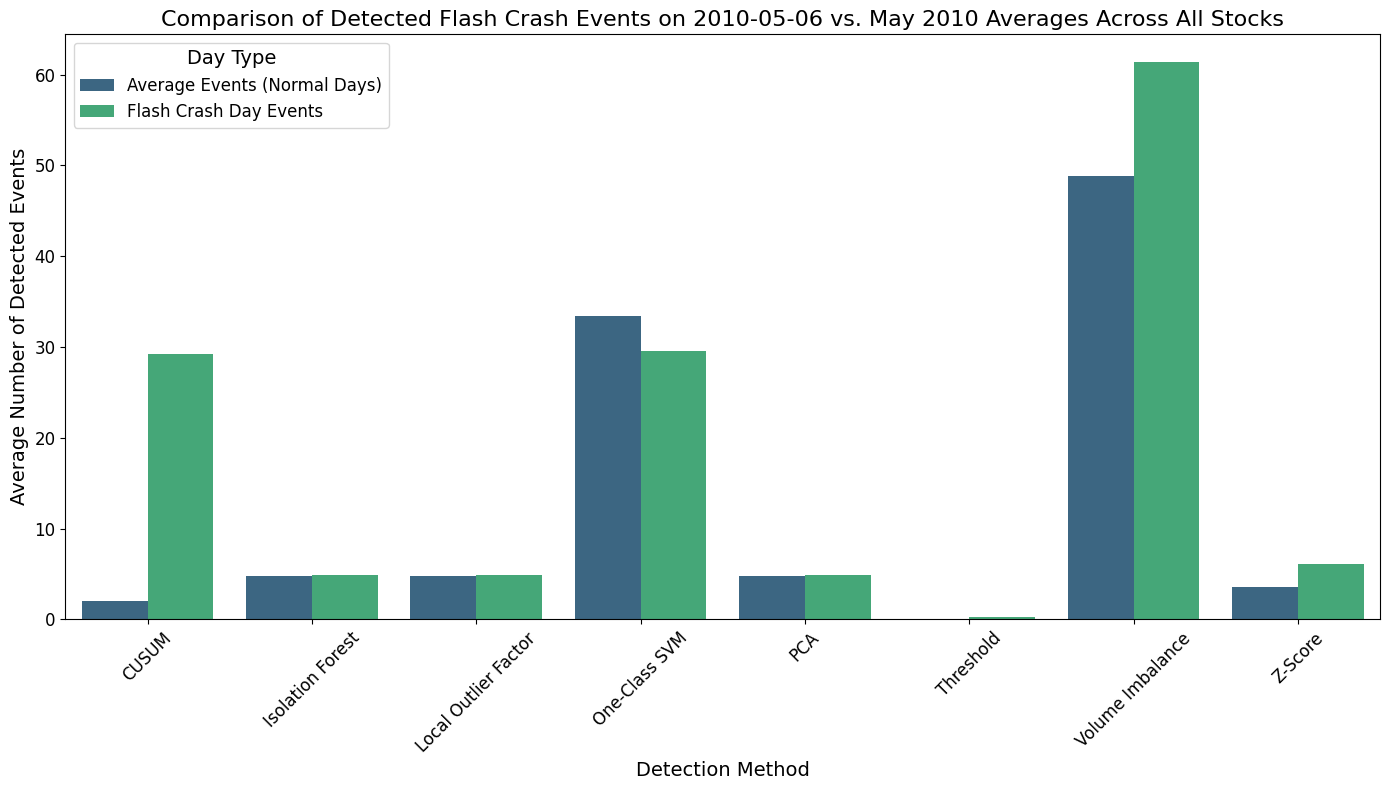

2025-01-24 21:02:04,698 - INFO - Aggregate results saved to 'aggregate_flash_crash_detection_results.csv'.


In [3]:
# ======================================================================
# IMPORTS
# ======================================================================
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import logging
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from tqdm import tqdm  # For progress bars

# Suppress warnings
warnings.filterwarnings("ignore")

# ======================================================================
# CONFIGURATION
# ======================================================================
BASE_DIR = "SP500_2010_extracted"  # Path to your data directory

# Define all trading days in May 2010
TRADING_DATES_MAY_2010 = [
    "2010-05-03", "2010-05-04", "2010-05-05",
    "2010-05-06",  # Flash Crash Day
    "2010-05-07", "2010-05-10", "2010-05-11",
    "2010-05-12", "2010-05-13", "2010-05-14",
    "2010-05-17", "2010-05-18", "2010-05-19",
    "2010-05-20", "2010-05-21", "2010-05-24",
    "2010-05-25", "2010-05-26", "2010-05-27",
    "2010-05-28"
]

FLASH_CRASH_DATE = "2010-05-06"
NORMAL_DAYS_MAY_2010 = [date for date in TRADING_DATES_MAY_2010 if date != FLASH_CRASH_DATE]

# Numeric columns to force to Float64 (adjust as needed)
FORCED_NUMERIC_COLS = [
    "trade_price", "trade_volume",
    "bid_price", "bid_size",
    "ask_price", "ask_size",
    # Add other columns if needed: e.g., "mid_price", "spread", etc.
]

# ======================================================================
# LOGGING CONFIGURATION
# ======================================================================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("flash_crash_detection.log"),
        logging.StreamHandler()
    ]
)

# ======================================================================
# HELPER FUNCTIONS: Data Loading & Filtering using Polars
# ======================================================================
def find_processed_files(base_dir: str):
    """
    Yields full paths to all files ending with '-processed.csv' in subfolders.
    """
    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname.endswith("-processed.csv"):
                yield os.path.join(root, fname)

def parse_ticker_date_from_filename(fname: str):
    """
    Expects a filename such as '2010-05-06-XOM-processed.csv'
    Returns (date_str, ticker) or (None, None) if format is incorrect.
    """
    base = os.path.basename(fname)
    parts = base.split("-")
    if len(parts) < 5:
        return None, None
    date_str = "-".join(parts[0:3])
    ticker = parts[3]
    return date_str, ticker

def process_single_file(csv_path: str) -> pl.DataFrame:
    """
    Opens one CSV file with forced dtypes, adds date and ticker columns.
    Returns a Polars DataFrame only if the file corresponds to a valid date and contains required columns.
    """
    date_str, ticker = parse_ticker_date_from_filename(csv_path)
    if not date_str or not ticker:
        logging.warning(f"Filename format incorrect: {csv_path}")
        return pl.DataFrame()
    # Check if date is one of the specified dates
    if date_str not in TRADING_DATES_MAY_2010:
        return pl.DataFrame()
    
    dtype_map = {col: pl.Float64 for col in FORCED_NUMERIC_COLS}
    try:
        # Corrected parameter: replaced 'sep' with 'separator'
        lf = pl.scan_csv(
            csv_path,
            has_header=True,
            separator=',',
            schema_overrides=dtype_map,
            ignore_errors=True
        )
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        return pl.DataFrame()
    
    # Add 'date' and 'ticker' columns
    lf = lf.with_columns([
        pl.lit(date_str).alias("date"),
        pl.lit(ticker).alias("ticker")
    ])
    
    # Collect the DataFrame
    try:
        df = lf.collect()
    except Exception as e:
        logging.error(f"Error collecting data from {csv_path}: {e}")
        return pl.DataFrame()
    
    # Convert 'timestamp' to datetime and drop rows with invalid timestamps
    if "timestamp" in df.columns:
        df = df.with_columns(
            pl.col("timestamp").str.to_datetime(strict=False)
        ).drop_nulls(subset=["timestamp"])
    else:
        logging.warning(f"'timestamp' column missing in {csv_path}")
        return pl.DataFrame()
    
    return df.sort(["ticker", "date", "timestamp"])

def get_dates_df(df_list: list, ticker: str, dates: list) -> pl.DataFrame:
    """
    Concatenates a list of Polars DataFrames and filters to specific ticker and dates.
    """
    if not df_list:
        return pl.DataFrame()
    try:
        df_combined = pl.concat(df_list, how="vertical")
    except Exception as e:
        logging.error(f"Error concatenating DataFrames for ticker {ticker}: {e}")
        return pl.DataFrame()
    try:
        filtered_df = df_combined.filter(
            (pl.col("ticker") == ticker) &
            (pl.col("date").is_in(dates))
        ).sort("timestamp")
    except Exception as e:
        logging.error(f"Error filtering DataFrames for ticker {ticker}: {e}")
        return pl.DataFrame()
    return filtered_df

# ======================================================================
# HELPER FUNCTIONS: Flash Crash Detection Specific
# ======================================================================
def isolation_forest_anomaly_detection(df_features, contamination=0.01):
    """
    Apply the Isolation Forest anomaly detection algorithm on a DataFrame of features.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df_features['anomaly'] = iso_forest.fit_predict(df_features)
    return df_features

def local_outlier_factor_detection(df_features, contamination=0.01):
    """
    Apply the Local Outlier Factor (LOF) anomaly detection.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    anomaly_labels = lof.fit_predict(df_features)
    df_features['anomaly'] = anomaly_labels
    return df_features

def one_class_svm_anomaly_detection(df_features, contamination=0.01):
    """
    Apply the One-Class SVM anomaly detection algorithm.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    svm = OneClassSVM(nu=contamination, kernel="rbf", gamma='scale')
    svm.fit(df_features)
    anomaly_labels = svm.predict(df_features)
    df_features['anomaly'] = anomaly_labels
    return df_features

def pca_anomaly_detection(df_features, contamination=0.01, n_components=2):
    """
    Apply PCA for dimensionality reduction followed by Isolation Forest for anomaly detection.
    Returns the original DataFrame with an added column 'anomaly' (-1 for anomalies, 1 for normal).
    """
    pca = PCA(n_components=n_components, random_state=42)
    principal_components = pca.fit_transform(df_features)
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomaly_labels = iso_forest.fit_predict(principal_components)
    df_features['anomaly'] = anomaly_labels
    return df_features

# ======================================================================
# HELPER FUNCTION: Apply Detection Methods
# ======================================================================
def apply_detection_methods(df_target):
    """
    Applies various flash crash detection methods on the target DataFrame.
    Returns a dictionary with counts of detected events per method.
    """
    method_event_counts = {}  # Dictionary to store counts per method

    # 1. Threshold-Based Detection
    threshold = -0.03  # 3% drop
    threshold_events = df_target[df_target['return'] < threshold]
    method_event_counts['Threshold'] = len(threshold_events)

    # 2. Volatility Z-Score Detection
    window = 30  # 30-minute rolling window
    z_threshold = 3.0
    rolling_mean = df_target['return'].rolling(window=window).mean()
    rolling_std = df_target['return'].rolling(window=window).std()
    z_scores = (df_target['return'] - rolling_mean) / rolling_std
    df_target['z_score'] = z_scores
    z_events = df_target[abs(df_target['z_score']) > z_threshold]
    method_event_counts['Z-Score'] = len(z_events)

    # 3. Volume Imbalance Detection
    vol_mean = df_target['trade_volume'].mean()
    vol_std = df_target['trade_volume'].std()
    vol_threshold = vol_mean + 2 * vol_std  # Mean + 2*Std
    vol_spikes = df_target[df_target['trade_volume'] > vol_threshold]
    method_event_counts['Volume Imbalance'] = len(vol_spikes)

    # 4. CUSUM Detection
    def cusum_detection(df_returns, threshold=0.03, drift=0.001):
        """
        Apply a simple CUSUM algorithm to a return series.
        Returns cumulative sums.
        """
        s_pos = np.zeros(len(df_returns))
        s_neg = np.zeros(len(df_returns))
        
        for i in range(1, len(df_returns)):
            s_pos[i] = max(0, s_pos[i-1] + df_returns.iloc[i] - drift)
            s_neg[i] = min(0, s_neg[i-1] + df_returns.iloc[i] + drift)
        return s_pos, s_neg

    returns_1min = df_target['return']
    s_pos, s_neg = cusum_detection(returns_1min, threshold=0.03, drift=0.001)
    df_target['CUSUM_Pos'] = pd.Series(s_pos, index=df_target.index)
    df_target['CUSUM_Neg'] = pd.Series(s_neg, index=df_target.index)

    # Identify CUSUM Events
    cusum_alerts = df_target[
        (df_target['CUSUM_Pos'] > 0.03) | 
        (df_target['CUSUM_Neg'] < -0.03)
    ]
    method_event_counts['CUSUM'] = len(cusum_alerts)

    # 5. Unsupervised Learning Methods
    df_features = pd.DataFrame({
        'return': df_target['return'],
        'trade_volume': df_target['trade_volume'],
        'z_score': df_target['z_score']
    }).dropna()

    if not df_features.empty:
        # 5.1 Isolation Forest
        df_if = isolation_forest_anomaly_detection(df_features.copy(), contamination=0.01)
        if_anomalies = df_if[df_if['anomaly'] == -1]
        method_event_counts['Isolation Forest'] = len(if_anomalies)

        # 5.2 Local Outlier Factor (LOF)
        df_lof = local_outlier_factor_detection(df_features.copy(), contamination=0.01)
        lof_anomalies = df_lof[df_lof['anomaly'] == -1]
        method_event_counts['Local Outlier Factor'] = len(lof_anomalies)

        # 5.3 One-Class SVM
        df_svm = one_class_svm_anomaly_detection(df_features.copy(), contamination=0.01)
        svm_anomalies = df_svm[df_svm['anomaly'] == -1]
        method_event_counts['One-Class SVM'] = len(svm_anomalies)

        # 5.4 Principal Component Analysis (PCA) for Anomaly Detection
        df_pca = pca_anomaly_detection(df_features.copy(), contamination=0.01, n_components=2)
        pca_anomalies = df_pca[df_pca['anomaly'] == -1]
        method_event_counts['PCA'] = len(pca_anomalies)
    else:
        # Add zero counts for unsupervised methods if no features are available
        method_event_counts['Isolation Forest'] = 0
        method_event_counts['Local Outlier Factor'] = 0
        method_event_counts['One-Class SVM'] = 0
        method_event_counts['PCA'] = 0

    return method_event_counts

# ======================================================================
# MAIN FLASH CRASH DETECTION ANALYSIS
# ======================================================================
def main():
    # Initialize a list to store results
    results = []

    # Collect all processed files
    logging.info("Scanning for processed CSV files...")
    all_files = list(find_processed_files(BASE_DIR))
    logging.info(f"Total processed files found: {len(all_files)}")

    # Group files by ticker
    ticker_files_map = {}
    for file_path in all_files:
        date_str, ticker = parse_ticker_date_from_filename(file_path)
        if not ticker or not date_str:
            continue
        ticker_files_map.setdefault(ticker, []).append(file_path)
    
    logging.info(f"Total tickers to process: {len(ticker_files_map)}")

    # Iterate through each ticker with a progress bar
    for ticker in tqdm(ticker_files_map.keys(), desc="Processing Tickers"):
        try:
            ticker_files = ticker_files_map[ticker]
            # Process each file for the ticker
            df_list = []
            for file in ticker_files:
                df = process_single_file(file)
                if not df.is_empty():
                    df_list.append(df)
            # Concatenate and filter data
            df_dates_polars = get_dates_df(df_list, ticker, TRADING_DATES_MAY_2010)
            del df_list  # Free memory
            gc.collect()

            if df_dates_polars.is_empty():
                logging.warning(f"No data for ticker {ticker} on specified dates.")
                continue

            # Convert to Pandas DataFrame
            try:
                df = df_dates_polars.to_pandas()
            except Exception as e:
                logging.error(f"Error converting Polars DataFrame to Pandas for ticker {ticker}: {e}")
                continue
            del df_dates_polars  # Free memory
            gc.collect()

            # Timezone Conversion
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            df.dropna(subset=['timestamp'], inplace=True)  # Drop rows with invalid timestamps
            try:
                ny_index = pd.DatetimeIndex(df['timestamp']).tz_localize('UTC').tz_convert('America/New_York')
            except Exception as e:
                logging.error(f"Timezone conversion failed for ticker {ticker}: {e}")
                continue
            df.set_index(ny_index, inplace=True)
            df.drop(columns=['timestamp', 'date', 'ticker'], inplace=True)  # Drop unnecessary columns

            # Resampling to 1-Minute Intervals
            df_1min = df.resample('1T').agg({
                'trade_price': 'ohlc',
                'trade_volume': 'sum'
            })
            df_1min.columns = ['open', 'high', 'low', 'close', 'trade_volume']
            
            # Calculate 1-minute returns
            df_1min['return'] = df_1min['close'].pct_change()
            
            # Drop the first row with NaN return
            df_1min.dropna(subset=['return'], inplace=True)

            # Separate Data by Date
            df_1min['date'] = df_1min.index.date
            flash_crash_day = pd.to_datetime(FLASH_CRASH_DATE).date()
            normal_days = [pd.to_datetime(date).date() for date in NORMAL_DAYS_MAY_2010]
            df_flash = df_1min[df_1min['date'] == flash_crash_day]
            df_normals = df_1min[df_1min['date'].isin(normal_days)]

            # Apply Detection Methods on Normal Days
            if not df_normals.empty:
                # Initialize cumulative counts
                cumulative_event_counts = {
                    'Threshold': 0,
                    'Z-Score': 0,
                    'Volume Imbalance': 0,
                    'CUSUM': 0,
                    'Isolation Forest': 0,
                    'Local Outlier Factor': 0,
                    'One-Class SVM': 0,
                    'PCA': 0
                }
                normal_day_dates = df_normals['date'].unique()
                for day in normal_day_dates:
                    df_day = df_normals[df_normals['date'] == day]
                    method_counts = apply_detection_methods(df_day)
                    for method, count in method_counts.items():
                        cumulative_event_counts[method] += count
                # Calculate averages
                average_event_counts = {method: count / len(normal_day_dates) for method, count in cumulative_event_counts.items()}
            else:
                logging.warning(f"No normal trading days data for ticker {ticker}.")
                average_event_counts = {
                    'Threshold': 0,
                    'Z-Score': 0,
                    'Volume Imbalance': 0,
                    'CUSUM': 0,
                    'Isolation Forest': 0,
                    'Local Outlier Factor': 0,
                    'One-Class SVM': 0,
                    'PCA': 0
                }

            # Apply Detection Methods on Flash Crash Day
            if not df_flash.empty:
                method_counts_flash = apply_detection_methods(df_flash)
            else:
                logging.warning(f"No flash crash day data for ticker {ticker}.")
                method_counts_flash = {
                    'Threshold': 0,
                    'Z-Score': 0,
                    'Volume Imbalance': 0,
                    'CUSUM': 0,
                    'Isolation Forest': 0,
                    'Local Outlier Factor': 0,
                    'One-Class SVM': 0,
                    'PCA': 0
                }

            # Append results
            for method in cumulative_event_counts.keys():
                results.append({
                    'Ticker': ticker,
                    'Method': method,
                    'Average Events (Normal Days)': average_event_counts.get(method, 0),
                    'Flash Crash Day Events': method_counts_flash.get(method, 0)
                })

            # Clear variables and collect garbage
            del df, df_1min, df_flash, df_normals, method_counts_flash
            gc.collect()

        except Exception as e:
            logging.error(f"An error occurred while processing ticker {ticker}: {e}")
            continue

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    if results_df.empty:
        logging.error("No data was processed successfully. Please check your CSV files and ensure they contain the required data.")
        return

    # Aggregate results across all tickers
    try:
        aggregate_df = results_df.groupby('Method').agg({
            'Average Events (Normal Days)': 'mean',
            'Flash Crash Day Events': 'mean'
        }).reset_index()
    except Exception as e:
        logging.error(f"Error aggregating results: {e}")
        return

    # Plot Comparison
    try:
        df_melted = aggregate_df.melt(
            id_vars='Method', 
            value_vars=['Average Events (Normal Days)', 'Flash Crash Day Events'],
            var_name='Day Type', 
            value_name='Events'
        )

        plt.figure(figsize=(14, 8))
        sns.barplot(
            x='Method', 
            y='Events', 
            hue='Day Type', 
            data=df_melted, 
            palette='viridis'
        )
        plt.title("Comparison of Detected Flash Crash Events on 2010-05-06 vs. May 2010 Averages Across All Stocks", fontsize=16)
        plt.xlabel("Detection Method", fontsize=14)
        plt.ylabel("Average Number of Detected Events", fontsize=14)
        plt.legend(title='Day Type', fontsize=12, title_fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        logging.error(f"Error generating the comparison plot: {e}")

    # Save the aggregate results to a CSV file
    try:
        aggregate_df.to_csv("aggregate_flash_crash_detection_results.csv", index=False)
        logging.info("Aggregate results saved to 'aggregate_flash_crash_detection_results.csv'.")
    except Exception as e:
        logging.error(f"Error saving aggregate results to CSV: {e}")

# ======================================================================
# ENTRY POINT
# ======================================================================
if __name__ == "__main__":
    main()